# Week 3 - Attitude Control of States and Rates

In Module 2, Lyapunov theory was introduced as a general tool for analyzing nonlinear stability.  
We learned how to construct scalar “energy-like” functions and use their time derivatives to argue stability without solving the equations of motion.

In this module, we apply that framework to a concrete and important problem:

**three-axis spacecraft attitude control.**

The objective is no longer just to eliminate motion, but to simultaneously regulate:

- **angular velocity (rate errors)**, and  
- **attitude (orientation errors)**.

A nonlinear full-state control law is developed using Lyapunov’s direct method.  
The stability of the resulting closed-loop system is analyzed rigorously, and convergence properties are examined under both modeled and unmodeled disturbance torques.

Beyond stability proofs, this module also connects theory to implementation:

- error measures for attitude and angular velocity are constructed,
- control torques are shaped using Lyapunov analysis,
- gain selection is discussed using the linearized closed-loop dynamics,
- and numerical simulations are used to verify behavior.

By the end of this module, you should be able to:

- construct rate and attitude error measures for a 3-axis spacecraft,
- design a Lyapunov-based nonlinear control law,
- argue stability and convergence analytically,
- and interpret closed-loop behavior through simulation.

This module marks the transition from stability analysis to practical nonlinear control design.

---

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time

import sys
sys.path.insert(0, r"../../")
import AttitudeKinematicsLib as ak

In [2]:
print("Contents of AttitudeKinematicsLib:")
for name in sorted(dir(ak)):
    if not name.startswith("_"):
        print(name)

Contents of AttitudeKinematicsLib:
BInvmat_CRP
BInvmat_EP
BInvmat_Euler
BInvmat_MRP
BInvmat_PRV
Bmat_CRP
Bmat_EP
Bmat_Euler
Bmat_MRP
Bmat_PRV
CRP
CRP_to_DCM
DCM_to_CRP
DCM_to_EP
DCM_to_Euler
DCM_to_MRP
DCM_to_PRV
DCM_utils
EP_to_DCM
EulerAngles
EulerRodriguesParameters
Euler_to_DCM
MRP
MRP_shadow
MRP_to_DCM
PRV
PRV_to_DCM
integrate_quaternion
normalize_quat
np
quat_derivative
quat_diff
quat_inv
quat_mult
rotation_matrix_x
rotation_matrix_y
rotation_matrix_z
skew_symmetric
solve_ivp
validate_DCM
validate_vec3
validate_vec4


# 3.1 - Problem Formulation and Objectives

We consider the rotational motion of a rigid spacecraft modeled as a torque-driven rigid body with constant, known inertia. The objective is to design a nonlinear three-axis attitude control law that asymptotically stabilizes both orientation and angular velocity using Lyapunov theory. Full-state feedback and unconstrained control torques are assumed.

The rigid-body rotational dynamics expressed in the body frame are

$$
[I]\dot{\boldsymbol{\omega}} =
- \tilde{\boldsymbol{\omega}} [I] \boldsymbol{\omega}
+ \boldsymbol{u}
+ \boldsymbol{d},
$$

where $[I] = [I]^T > 0$ is the constant inertia matrix, $\boldsymbol{\omega} \in \mathbb{R}^3$ is the body angular velocity, $\tilde{\boldsymbol{\omega}}$ is the skew-symmetric matrix satisfying $\tilde{\boldsymbol{\omega}}\boldsymbol{v} = \boldsymbol{\omega} \times \boldsymbol{v}$, $\boldsymbol{u}$ is the control torque, and $\boldsymbol{d}$ represents disturbance torques. The gyroscopic term satisfies

$$
\boldsymbol{\omega}^T (-\tilde{\boldsymbol{\omega}}[I]\boldsymbol{\omega}) = 0,
$$

which implies it neither injects nor dissipates rotational kinetic energy. This structural property is fundamental for Lyapunov-based control design.

Attitude is represented using Modified Rodrigues Parameters (MRPs), $\boldsymbol{\sigma} \in \mathbb{R}^3$, with kinematics

$$
\dot{\boldsymbol{\sigma}} = [B(\boldsymbol{\sigma})]\boldsymbol{\omega},
$$

where $[B(\boldsymbol{\sigma})]$ is the nonlinear MRP kinematic matrix. The complete state is

$$
x =
\begin{bmatrix}
\boldsymbol{\sigma} \\
\boldsymbol{\omega}
\end{bmatrix}.
$$

The system is nonlinear due to the MRP kinematics and the gyroscopic coupling in the dynamics. Linear control laws designed about small-angle equilibria do not capture global rotational behavior, motivating a nonlinear formulation.

Let the desired attitude and angular velocity be $\boldsymbol{\sigma}_r$ and $\boldsymbol{\omega}_r$. The relative attitude error is defined through MRP composition as

$$
\boldsymbol{\sigma}_e = \boldsymbol{\sigma} \oplus (-\boldsymbol{\sigma}_r),
$$

which represents the MRP parameterization of the relative rotation between the body and reference frames. The angular velocity error for regulation problems is

$$
\boldsymbol{\omega}_e = \boldsymbol{\omega} - \boldsymbol{\omega}_r.
$$

For rest-to-rest stabilization, $\boldsymbol{\sigma}_r = \mathbf{0}$ and $\boldsymbol{\omega}_r = \mathbf{0}$, reducing the errors to the physical states. The equilibrium of interest is therefore

$$
(\boldsymbol{\sigma}_e, \boldsymbol{\omega}_e) = (\mathbf{0}, \mathbf{0}).
$$

Using MRP error kinematics, the attitude error evolves as

$$
\dot{\boldsymbol{\sigma}}_e = [B(\boldsymbol{\sigma}_e)]\boldsymbol{\omega}_e,
$$

which preserves the nonlinear structure of the original kinematics and enables direct Lyapunov construction on the error states.

__The control objective__ is asymptotic convergence of the error states,

$$
\boldsymbol{\sigma}_e(t) \rightarrow \mathbf{0}, 
\qquad 
\boldsymbol{\omega}_e(t) \rightarrow \mathbf{0}, 
\quad \text{as } t \rightarrow \infty.
$$

In the absence of disturbances, asymptotic stability of the equilibrium is desired. In the presence of bounded disturbances, stability and bounded error behavior are required, with disturbance rejection addressed later via integral feedback augmentation.

# 3.2 - Nonlinear 3-Axis Attitude Control Law

We begin with the exact attitude tracking error kinematics expressed in MRPs. These equations describe how the orientation error evolves as a function of the angular velocity error:

$$
\dot{\boldsymbol{\sigma}} =
\frac{1}{4}\Big[(1-\boldsymbol{\sigma}^T\boldsymbol{\sigma})[I]
+2[\tilde{\boldsymbol{\sigma}}]
+2\boldsymbol{\sigma}\boldsymbol{\sigma}^T\Big]\delta\boldsymbol{\omega}
\;\triangleq\;
[B(\boldsymbol{\sigma})]\delta\boldsymbol{\omega}.
$$

Define the angular velocity tracking error in the body frame as

$$
\delta\boldsymbol{\omega} = \boldsymbol{\omega} - \boldsymbol{\omega}_r.
$$

The control objective is to drive both $\boldsymbol{\sigma} \to \mathbf{0}$ and $\delta\boldsymbol{\omega} \to \mathbf{0}$. Rather than guessing a control law, we construct one systematically by selecting a Lyapunov function and forcing its time derivative to be non-positive.

Choose the Lyapunov candidate

$$
V(\delta\boldsymbol{\omega},\boldsymbol{\sigma}) =
\frac{1}{2}\delta\boldsymbol{\omega}^T[I]\delta\boldsymbol{\omega}
+ 2K\ln(1+\boldsymbol{\sigma}^T\boldsymbol{\sigma}), \qquad K>0.
$$

The first term is the rotational kinetic energy associated with the rate error. The second term is a positive-definite potential function in the MRP error; it behaves quadratically near the origin but grows without bound as the attitude error increases. Thus $V$ measures total “energy” in the error states.

Differentiating $V$ gives

$$
\dot V =
\delta\boldsymbol{\omega}^T
\left([I]\;{}^{B}\frac{d}{dt}(\delta\boldsymbol{\omega}) + K\boldsymbol{\sigma}\right).
$$

The structure is important: $\dot V$ is linear in $\delta\boldsymbol{\omega}$. This means we can shape $\dot V$ directly by shaping the rate dynamics.

__To guarantee stability__, we enforce negative semi-definiteness by prescribing

$$
\dot V =
-\delta\boldsymbol{\omega}^T[P]\delta\boldsymbol{\omega}, \qquad [P]=[P]^T>0.
$$

This choice ensures that the Lyapunov function never increases, meaning the total error “energy” cannot grow.

Matching terms yields the desired closed-loop error dynamics

$$
[I]\;{}^{B}\frac{d}{dt}(\delta\boldsymbol{\omega})
+ [P]\delta\boldsymbol{\omega}
+ K\boldsymbol{\sigma} =
\mathbf{0}.
$$

This equation has a clear interpretation: inertia times acceleration plus damping plus a restoring torque proportional to attitude error equals zero. It is the nonlinear rotational analogue of a damped spring–mass system.

Using the body-frame derivative relation

$$
{}^{B}\frac{d}{dt}(\delta\boldsymbol{\omega}) = 
\dot{\boldsymbol{\omega}}
- \dot{\boldsymbol{\omega}}_r
+ \boldsymbol{\omega}\times\boldsymbol{\omega}_r,
$$

we express the closed-loop condition in terms of physical variables:

$$
[I]
\left(\dot{\boldsymbol{\omega}} - \dot{\boldsymbol{\omega}}_r + \boldsymbol{\omega}\times\boldsymbol{\omega}_r \right)
+ [P](\boldsymbol{\omega}-\boldsymbol{\omega}_r)
+ K\boldsymbol{\sigma} =
\mathbf{0}.
$$

Substituting the rigid-body equation of motion

$$
[I]\dot{\boldsymbol{\omega}} =
- [\tilde{\boldsymbol{\omega}}][I]\boldsymbol{\omega}
+ \boldsymbol{u}
+ \boldsymbol{L},
$$

and solving for the control torque gives the nonlinear feedback law

$$
\boldsymbol{u} =
- K\boldsymbol{\sigma}
- [P]\delta\boldsymbol{\omega}
+ [I]\left(\dot{\boldsymbol{\omega}}_r
- [\tilde{\boldsymbol{\omega}}]\boldsymbol{\omega}_r\right)
+ [\tilde{\boldsymbol{\omega}}][I]\boldsymbol{\omega}
- \boldsymbol{L}.
$$

Each term has a physical role: $-K\boldsymbol{\sigma}$ restores attitude, $-[P]\delta\boldsymbol{\omega}$ provides damping, the inertia-weighted reference terms provide feedforward tracking, and the gyroscopic term cancels internal coupling.

With $\boldsymbol{L}=\mathbf{0}$, this control choice guarantees

$$
\dot V = -\delta\boldsymbol{\omega}^T[P]\delta\boldsymbol{\omega} \le 0,
$$

establishing Lyapunov stability of the tracking error dynamics.

V(0) = 1.361686813653049  | V(T) = 3.925054238336317e-11
Count of tiny V increases (Euler artifact, should be ~0): 395
max(Vdot_pred) = -8.10311693504884e-14 (should be <= 0, numerical noise aside)


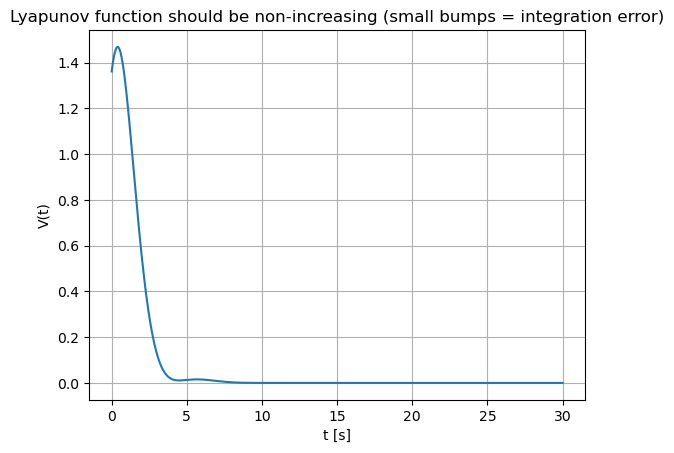

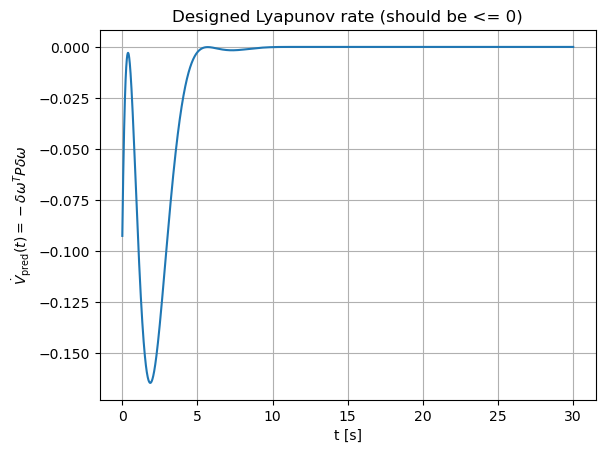

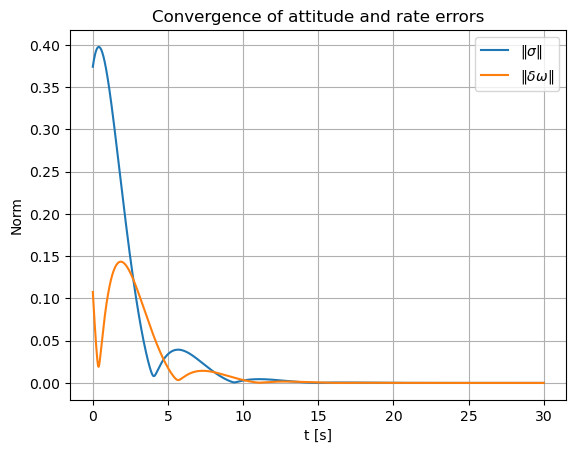

In [3]:
# --- Setup ---
dt = 0.01
T  = 30.0
t  = np.arange(0.0, T + dt, dt)
N  = len(t)

I = np.diag([10.0, 7.5, 5.0])
K = 5.0
P = np.diag([8.0, 8.0, 8.0])

# Regulation reference (simplest case)
omega_r     = np.zeros(3)
omega_r_dot = np.zeros(3)
L           = np.zeros(3)

# Initial condition (nonzero attitude + rate)
sigma = np.array([0.3, -0.2, 0.1], dtype=float)
omega = np.deg2rad(np.array([5.0, -3.0, 2.0], dtype=float))

# --- Logs ---
V_hist         = np.zeros(N)
Vdot_pred_hist = np.zeros(N)
sig_norm       = np.zeros(N)
dw_norm        = np.zeros(N)

# --- Sim loop (intentionally simple: Euler) ---
for k in range(N):
    domega = omega - omega_r

    # Lyapunov function: V = 1/2 domega^T I domega + 2K ln(1 + sigma^T sigma)
    V_hist[k] = 0.5 * domega.T @ I @ domega + 2.0 * K * np.log(1.0 + sigma.T @ sigma)

    # Predicted Lyapunov rate from design: Vdot = - domega^T P domega
    Vdot_pred_hist[k] = - domega.T @ P @ domega

    sig_norm[k] = np.linalg.norm(sigma)
    dw_norm[k]  = np.linalg.norm(domega)

    # Controller: u = -K sigma - P domega + I(omega_r_dot - [~omega] omega_r) + [~omega] I omega - L
    omega_tilde = ak.skew_symmetric(omega)
    u = (-K * sigma
         - P @ domega
         + I @ (omega_r_dot - omega_tilde @ omega_r)
         + omega_tilde @ (I @ omega)
         - L)

    # Dynamics: I wdot = -[~omega] I omega + u + L
    wdot = np.linalg.solve(I, (-omega_tilde @ (I @ omega) + u + L))

    # Kinematics: sigmadot = B(sigma) omega
    sigmadot = ak.Bmat_MRP(sigma) @ omega

    # Integrate (Euler)
    sigma = sigma + dt * sigmadot
    omega = omega + dt * wdot

    # Keep MRPs in principal set (previews Section 3.3)
    sigma = ak.MRP_shadow(sigma)

# --- Quick sanity prints ---
num_V_increases = np.sum(np.diff(V_hist) > 1e-9)
print("V(0) =", V_hist[0], " | V(T) =", V_hist[-1])
print("Count of tiny V increases (Euler artifact, should be ~0):", int(num_V_increases))
print("max(Vdot_pred) =", np.max(Vdot_pred_hist), "(should be <= 0, numerical noise aside)")

# --- Plots ---
plt.figure()
plt.plot(t, V_hist)
plt.xlabel("t [s]")
plt.ylabel("V(t)")
plt.title("Lyapunov function should be non-increasing (small bumps = integration error)")
plt.grid(True)

plt.figure()
plt.plot(t, Vdot_pred_hist)
plt.xlabel("t [s]")
plt.ylabel(r"$\dot V_{\mathrm{pred}}(t) = -\delta\omega^T P \delta\omega$")
plt.title("Designed Lyapunov rate (should be <= 0)")
plt.grid(True)

plt.figure()
plt.plot(t, sig_norm, label=r"$\|\sigma\|$")
plt.plot(t, dw_norm, label=r"$\|\delta\omega\|$")
plt.xlabel("t [s]")
plt.ylabel("Norm")
plt.title("Convergence of attitude and rate errors")
plt.grid(True)
plt.legend()

plt.show()

# 3.3 - Global stability and MRP switching

The Lyapunov function introduced previously,

$$
V(\delta\boldsymbol{\omega},\boldsymbol{\sigma}) =
\frac{1}{2}\delta\boldsymbol{\omega}^T[I]\delta\boldsymbol{\omega}
+
2K\ln\!\left(1+\boldsymbol{\sigma}^T\boldsymbol{\sigma}\right),
$$

is positive definite in both $\delta\boldsymbol{\omega}$ and $\boldsymbol{\sigma}$. The kinetic term is quadratic and radially unbounded in $\delta\boldsymbol{\omega}$ since $[I]=[I]^T>0$. The logarithmic term satisfies

$$
2K\ln(1+\boldsymbol{\sigma}^T\boldsymbol{\sigma}) \ge 0,
$$

with equality only at $\boldsymbol{\sigma}=\mathbf{0}$. As either $\|\delta\boldsymbol{\omega}\|\to\infty$ or $\|\boldsymbol{\sigma}\|\to\infty$, the function $V$ grows without bound. Therefore,

$$
V \rightarrow \infty
\quad \text{as} \quad
\|(\boldsymbol{\sigma},\delta\boldsymbol{\omega})\| \rightarrow \infty,
$$

so its level sets are compact. Because

$$
\dot V = -\delta\boldsymbol{\omega}^T[P]\delta\boldsymbol{\omega} \le 0,
$$

trajectories remain confined to bounded level sets for all time.

__At first glance this suggests global stability.__ However, attitude representations introduce an important geometric subtlety. Modified Rodrigues Parameters form a minimal three-parameter representation of attitude. No smooth minimal parameterization can globally cover the rotation group $SO(3)$ without singularity or redundancy. Thus, while the physical attitude space is compact, the coordinate chart itself is not globally unique.

For MRPs, a convenient switching surface is chosen as

$$
\boldsymbol{\sigma}^T\boldsymbol{\sigma} = 1,
$$

which corresponds to a $180^\circ$ rotation. The same physical rotation beyond this surface can be represented by the shadow set defined by

$$
\boldsymbol{\sigma}^S = -\frac{\boldsymbol{\sigma}}{\boldsymbol{\sigma}^T\boldsymbol{\sigma}}.
$$

Both $\boldsymbol{\sigma}$ and $\boldsymbol{\sigma}^S$ represent exactly the same rotation. The transformation merely selects the representation with smaller norm. By enforcing switching whenever $\boldsymbol{\sigma}^T\boldsymbol{\sigma} > 1$, we guarantee

$$
\boldsymbol{\sigma}^T\boldsymbol{\sigma} \le 1,
$$

so the state remains inside the principal MRP ball and avoids coordinate growth.

__The crucial observation is that the Lyapunov function is invariant under this mapping.__ Since $V$ depends only on $\boldsymbol{\sigma}^T\boldsymbol{\sigma}$, we have

$$
V(\boldsymbol{\sigma}^S,\delta\boldsymbol{\omega}) = V(\boldsymbol{\sigma},\delta\boldsymbol{\omega}).
$$

Thus, although the coordinates undergo a discrete reset at the switching surface, the Lyapunov function itself is continuous and unchanged. Its value never increases during switching.

The closed-loop system therefore becomes a hybrid system consisting of continuous flows and discrete switching events. During flows, $\dot V \le 0$. During switching, $V$ remains constant. Although the partial derivatives of $V$ are not continuous at the switching surface and classical smooth Lyapunov theorems cannot be directly invoked globally, the sequence of Lyapunov values remains non-increasing across both flows and jumps. This guarantees global stability of the hybrid closed-loop system.

It is important to distinguish stability from asymptotic stabilization on $SO(3)$. Smooth global asymptotic stabilization of rigid-body attitude is topologically impossible. However, with MRP switching, the controller achieves almost-global asymptotic stability: all initial conditions except a measure-zero set converge to the desired equilibrium. Furthermore, the switching mechanism ensures that the attitude error is always represented with the smallest rotation magnitude, preventing wind-up and enforcing shortest-path convergence.

The remaining question is whether convergence is merely Lyapunov stable or asymptotically convergent, which is examined next.

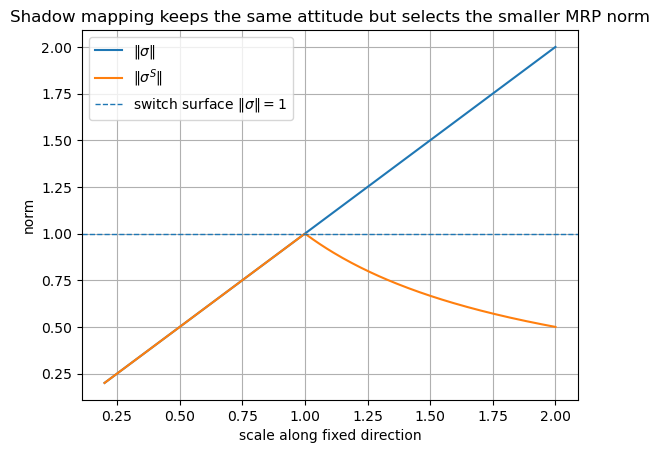

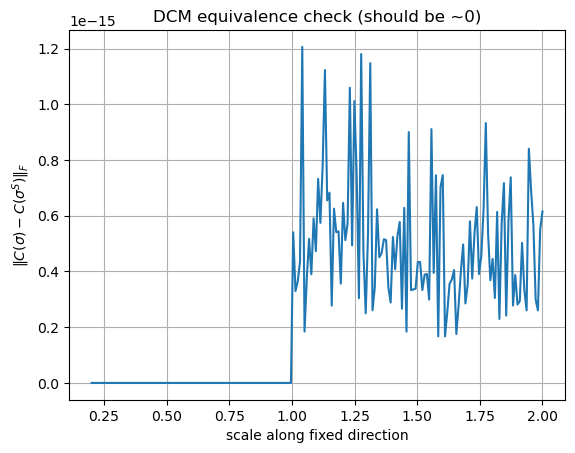

max DCM Frobenius error: 1.2057763275500464e-15


In [4]:
# Pick MRPs that cross the switching surface ||sigma|| = 1
# (start near 0.2, end near 2.0 along a fixed direction)
dir_vec = np.array([1.0, -0.3, 0.2])
dir_vec = dir_vec / np.linalg.norm(dir_vec)

s_vals = np.linspace(0.2, 2.0, 200)

sigma_norm = np.zeros_like(s_vals)
sigmaS_norm = np.zeros_like(s_vals)
dcm_err_fro = np.zeros_like(s_vals)

for k, s in enumerate(s_vals):
    sigma = s * dir_vec
    sigmaS = ak.MRP_shadow(sigma)

    sigma_norm[k] = np.linalg.norm(sigma)
    sigmaS_norm[k] = np.linalg.norm(sigmaS)

    # Same physical attitude check: DCM(sigma) should equal DCM(sigmaS)
    C  = ak.MRP_to_DCM(sigma)
    CS = ak.MRP_to_DCM(sigmaS)

    # Frobenius norm of difference (should be ~0 up to numerical precision)
    dcm_err_fro[k] = np.linalg.norm(C - CS, ord="fro")

# Plot 1: norms + switching surface
plt.figure()
plt.plot(s_vals, sigma_norm, label=r"$\|\sigma\|$")
plt.plot(s_vals, sigmaS_norm, label=r"$\|\sigma^S\|$")
plt.axhline(1.0, linestyle="--", linewidth=1.0, label=r"switch surface $\|\sigma\|=1$")
plt.xlabel("scale along fixed direction")
plt.ylabel("norm")
plt.title("Shadow mapping keeps the same attitude but selects the smaller MRP norm")
plt.grid(True)
plt.legend()

# Plot 2: DCM equivalence error
plt.figure()
plt.plot(s_vals, dcm_err_fro)
plt.xlabel("scale along fixed direction")
plt.ylabel(r"$\|C(\sigma)-C(\sigma^S)\|_F$")
plt.title("DCM equivalence check (should be ~0)")
plt.grid(True)

plt.show()

print("max DCM Frobenius error:", np.max(dcm_err_fro))

# 3.4 - Asymoptotic Convergence Analysis

From Section 3.2, the Lyapunov function satisfies

$$
\dot V = -\delta\boldsymbol{\omega}^T [P] \delta\boldsymbol{\omega} \le 0,
\qquad [P]=[P]^T>0.
$$

This guarantees Lyapunov stability and bounded trajectories. However, $\dot V$ is only negative semi-definite. It vanishes whenever

$$
\delta\boldsymbol{\omega} = \mathbf{0}.
$$

Thus, the Lyapunov argument alone does not yet prove asymptotic convergence. The system could, in principle, settle into motions where $\delta\boldsymbol{\omega}=0$ while $\boldsymbol{\sigma}\neq 0$.

To determine whether such motions are possible, we examine the invariant set defined by

$$
\Omega = \{ (\boldsymbol{\sigma},\delta\boldsymbol{\omega}) \mid \delta\boldsymbol{\omega} = \mathbf{0} \}.
$$

If a trajectory reaches this set and remains there, then asymptotic convergence is not guaranteed. We therefore test whether $\Omega$ is invariant under the closed-loop dynamics.

Recall the closed-loop error dynamics

$$
[I]\;{}^{B}\frac{d}{dt}(\delta\boldsymbol{\omega})
+ [P]\delta\boldsymbol{\omega}
+ K\boldsymbol{\sigma} =
\mathbf{0}.
$$

On the set $\delta\boldsymbol{\omega}=\mathbf{0}$, this reduces to

$$
[I]\;{}^{B}\frac{d}{dt}(\delta\boldsymbol{\omega})
+ K\boldsymbol{\sigma} =
\mathbf{0}.
$$

For $\delta\boldsymbol{\omega}=0$ to remain invariant, its derivative must also vanish. Therefore,

$$
K\boldsymbol{\sigma} = \mathbf{0}.
$$

Since $K>0$, this implies

$$
\boldsymbol{\sigma} = \mathbf{0}.
$$

__Hence the only state in $\Omega$ that can remain invariant is__

$$
(\boldsymbol{\sigma},\delta\boldsymbol{\omega}) = (\mathbf{0},\mathbf{0}).
$$

This shows that there are no nontrivial trajectories along which $\dot V=0$. The largest invariant set contained in $\{\dot V=0\}$ is the equilibrium itself.

An equivalent perspective, reflected in the slides, is to inspect higher derivatives of $V$. If $\dot V=0$, then $\delta\boldsymbol{\omega}=0$. Taking another time derivative and substituting the closed-loop dynamics forces $\boldsymbol{\sigma}=0$. This confirms that no other steady motion can persist.

By LaSalle’s Invariance Principle, all trajectories converge to the largest invariant set contained in $\{\dot V=0\}$. Since that set is the equilibrium alone, we conclude

$$
\boldsymbol{\sigma}(t) \rightarrow \mathbf{0},
\qquad
\delta\boldsymbol{\omega}(t) \rightarrow \mathbf{0},
\quad \text{as } t \rightarrow \infty.
$$

The equilibrium is therefore asymptotically stable.

When combined with the MRP shadow switching mechanism discussed previously, this convergence result holds almost globally on $SO(3)$.

In [5]:
# Inertia and gains
I = np.diag([10.0, 7.5, 5.0])
K = 5.0
P = np.diag([8.0, 8.0, 8.0])

# Pick a nonzero attitude error
sigma = np.array([0.3, -0.2, 0.1])

# Force delta omega = 0  (this is the set where Vdot = 0)
domega = np.zeros(3)

# Closed-loop dynamics:
# I * domega_dot + P*domega + K*sigma = 0
# With domega = 0:
# I * domega_dot + K*sigma = 0
# So:
domega_dot = -np.linalg.solve(I, K * sigma)

print("sigma =", sigma)
print("delta_omega =", domega)
print("delta_omega_dot =", domega_dot)

sigma = [ 0.3 -0.2  0.1]
delta_omega = [0. 0. 0.]
delta_omega_dot = [-0.15        0.13333333 -0.1       ]


The code above illustrates the core idea behind LaSalle’s Invariance Principle used in Section 3.4.

We intentionally set $\delta\boldsymbol{\omega} = \mathbf{0}$, which corresponds to the condition where

$$
\dot V = -\delta\boldsymbol{\omega}^T [P] \delta\boldsymbol{\omega} = 0.
$$

If asymptotic convergence were not guaranteed, it would be possible for the system to remain in this set with $\boldsymbol{\sigma} \neq \mathbf{0}$. In other words, the spacecraft could stop rotating while still having a nonzero attitude error.

However, substituting $\delta\boldsymbol{\omega} = \mathbf{0}$ into the closed-loop dynamics gives

$$
[I]\dot{\delta\boldsymbol{\omega}} + K\boldsymbol{\sigma} = \mathbf{0}
\quad \Rightarrow \quad
\dot{\delta\boldsymbol{\omega}} = -[I]^{-1}K\boldsymbol{\sigma}.
$$

Unless $\boldsymbol{\sigma} = \mathbf{0}$, this derivative is nonzero. The system therefore immediately generates angular acceleration and leaves the set $\delta\boldsymbol{\omega} = 0$.

This demonstrates that the set $\{\delta\boldsymbol{\omega}=0\}$ is not invariant unless $\boldsymbol{\sigma}=0$. The only trajectory that can remain in $\{\dot V=0\}$ is the equilibrium itself. By LaSalle’s Invariance Principle, all trajectories must therefore converge to

$$
(\boldsymbol{\sigma},\delta\boldsymbol{\omega}) = (\mathbf{0},\mathbf{0}),
$$

which establishes asymptotic stability.

# 3.5 - External Torque Model Error

The previous analysis assumed perfect cancellation of external torques. In practice, an unmodeled disturbance torque $\Delta\boldsymbol{L}$ is always present. The true rigid-body dynamics become

$$
[I]\dot{\boldsymbol{\omega}} =
- \tilde{\boldsymbol{\omega}} [I] \boldsymbol{\omega}
+ \boldsymbol{u}
+ \boldsymbol{L}
+ \Delta\boldsymbol{L}.
$$

Using the same nonlinear control law derived under the assumption $\Delta\boldsymbol{L}=0$, the closed-loop error dynamics now take the form

$$
[I]\;{}^{B}\frac{d}{dt}(\delta\boldsymbol{\omega})
+ [P]\delta\boldsymbol{\omega}
+ K\boldsymbol{\sigma} =
\Delta\boldsymbol{L}.
$$

The structure is identical to the nominal case, except that a constant forcing term appears on the right-hand side. The system now behaves like a nonlinear spring–mass–damper driven by a constant bias torque.

The Lyapunov function remains

$$
V =
\frac{1}{2}\delta\boldsymbol{\omega}^T[I]\delta\boldsymbol{\omega}
+ 2K\ln\!\left(1+\boldsymbol{\sigma}^T\boldsymbol{\sigma}\right),
$$

but its time derivative becomes

$$
\dot V =
- \delta\boldsymbol{\omega}^T[P]\delta\boldsymbol{\omega}
+ \delta\boldsymbol{\omega}^T \Delta\boldsymbol{L}.
$$

__This is no longer negative semi-definite.__  
The disturbance term $\delta\boldsymbol{\omega}^T \Delta\boldsymbol{L}$ represents energy injection. The Lyapunov function can increase if the disturbance work exceeds the damping term.

However, for sufficiently large $\|\delta\boldsymbol{\omega}\|$, the quadratic damping term dominates the linear disturbance term. Therefore, $\delta\boldsymbol{\omega}$ remains bounded. The controller still regulates angular velocity errors, even though perfect asymptotic convergence is lost.

To understand the steady-state behavior, consider the equilibrium condition

$$
[I]\;{}^{B}\frac{d}{dt}(\delta\boldsymbol{\omega})
+ [P]\delta\boldsymbol{\omega}
+ K\boldsymbol{\sigma} =
\Delta\boldsymbol{L}.
$$

At steady state, assume

$$
\delta\boldsymbol{\omega}_{ss} = \mathbf{0}, \qquad {}^{B}\frac{d}{dt}(\delta\boldsymbol{\omega}) = \mathbf{0}.
$$

The equilibrium condition reduces to

$$
K\boldsymbol{\sigma}_{ss} = \Delta\boldsymbol{L}.
$$

Hence,

$$
\boldsymbol{\sigma}_{ss} = \frac{1}{K}\Delta\boldsymbol{L}.
$$

The angular velocity error converges to zero, but the attitude error settles to a constant offset proportional to the disturbance torque.

Physically, the proportional term $K\boldsymbol{\sigma}$ acts as a nonlinear spring. A constant disturbance torque shifts the spring equilibrium until the restoring torque balances the disturbance. The controller behaves like a PD regulator with steady-state bias.

Two important conclusions follow:

- Increasing $K$ reduces the steady-state attitude error.
- Pure proportional–derivative feedback cannot reject constant disturbance torque.

The closed-loop system remains stable and bounded, but no longer converges to zero error. This motivates the introduction of integral feedback in the next section to eliminate steady-state attitude error under constant disturbances.

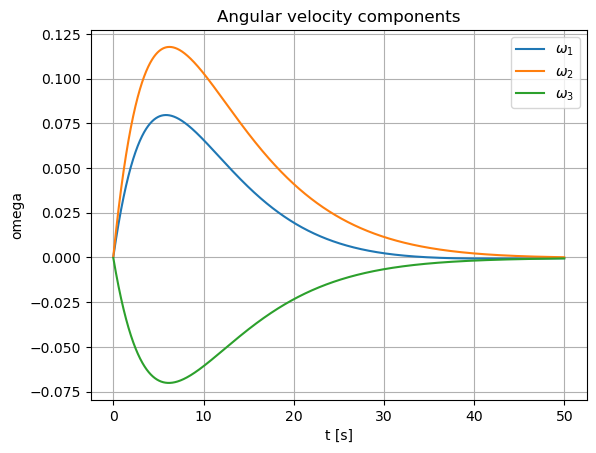

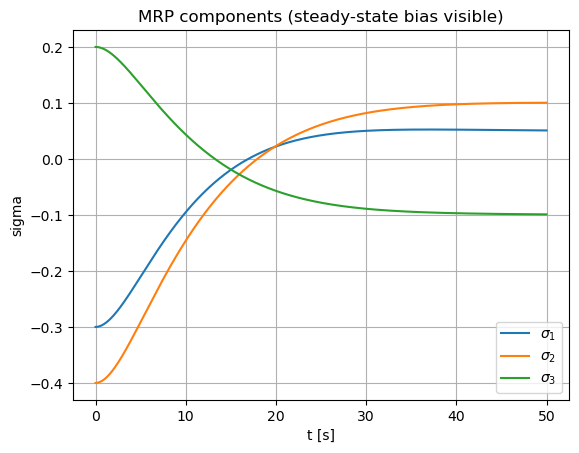

In [6]:
# Time
dt = 0.01
T  = 50.0
t  = np.arange(0, T, dt)
N  = len(t)

# System parameters
I = np.diag([10.0, 10.0, 10.0])
K = 1.0
P = np.diag([3.0, 3.0, 3.0])

# Constant disturbance torque
DeltaL = np.array([0.05, 0.10, -0.10])

# Initial condition
sigma = np.array([-0.3, -0.4, 0.2])
omega = np.zeros(3)

# Logs
sigma_hist = np.zeros((N,3))
omega_hist = np.zeros((N,3))

for k in range(N):

    domega = omega  # regulation case

    # Controller (no disturbance compensation)
    omega_tilde = ak.skew_symmetric(omega)
    u = -K*sigma - P@domega + omega_tilde@(I@omega)

    # True dynamics include disturbance
    wdot = np.linalg.solve(I, -omega_tilde@(I@omega) + u + DeltaL)

    sigmadot = 0.25 * ak.Bmat_MRP(sigma) @ omega

    # Euler integration (intentionally simple)
    omega = omega + dt*wdot
    sigma = sigma + dt*sigmadot
    sigma = ak.MRP_shadow(sigma)

    sigma_hist[k] = sigma
    omega_hist[k] = omega

# Plot omega components
plt.figure()
plt.plot(t, omega_hist[:,0], label=r'$\omega_1$')
plt.plot(t, omega_hist[:,1], label=r'$\omega_2$')
plt.plot(t, omega_hist[:,2], label=r'$\omega_3$')
plt.title("Angular velocity components")
plt.xlabel("t [s]")
plt.ylabel("omega")
plt.grid(True)
plt.legend()

# Plot sigma components
plt.figure()
plt.plot(t, sigma_hist[:,0], label=r'$\sigma_1$')
plt.plot(t, sigma_hist[:,1], label=r'$\sigma_2$')
plt.plot(t, sigma_hist[:,2], label=r'$\sigma_3$')
plt.title("MRP components (steady-state bias visible)")
plt.xlabel("t [s]")
plt.ylabel("sigma")
plt.grid(True)
plt.legend()

plt.show()

# 3.6 - Integral Feedback for Disurbance Rejection

Section 3.5 showed that a constant disturbance torque produces a steady-state attitude bias under PD control,

$$
\boldsymbol{\sigma}_{ss} = \frac{1}{K}\Delta\boldsymbol{L}.
$$

To eliminate this bias, integral action is introduced.

Define a new integral state

$$
\boldsymbol{z}(t) = \int_0^t \left( K\boldsymbol{\sigma} + [I]\delta\dot{\boldsymbol{\omega}} \right) d\tau.
$$

Using the closed-loop dynamics, this can be written equivalently as

$$
\boldsymbol{z}(t) = K\int_0^t \boldsymbol{\sigma}\, d\tau + [I](\delta\boldsymbol{\omega}-\delta\boldsymbol{\omega}_0),
$$

which shows that any persistent attitude error causes $\boldsymbol{z}$ to grow. The integral channel therefore accumulates steady-state error and generates a compensating torque.

Augment the Lyapunov function to include the integral energy:

$$
V(\delta\boldsymbol{\omega},\boldsymbol{\sigma},\boldsymbol{z}) =
\frac{1}{2}\delta\boldsymbol{\omega}^T[I]\delta\boldsymbol{\omega}
+ 2K\ln(1+\boldsymbol{\sigma}^T\boldsymbol{\sigma})
+ \frac{1}{2}\boldsymbol{z}^T[K_I]\boldsymbol{z},
$$

with $[K_I]=[K_I]^T>0$.

Choose the control input such that

$$
\dot V = -(\delta\boldsymbol{\omega}+[K_I]\boldsymbol{z})^T [P] (\delta\boldsymbol{\omega}+[K_I]\boldsymbol{z}),
$$

which yields the augmented feedback law

$$
\boldsymbol{u} =
- K\boldsymbol{\sigma}
-[P]\delta\boldsymbol{\omega}
-[P][K_I]\boldsymbol{z}
+ [I](\dot{\boldsymbol{\omega}}_r-[\tilde{\boldsymbol{\omega}}]\boldsymbol{\omega}_r)
+ [\tilde{\boldsymbol{\omega}}][I]\boldsymbol{\omega}
- \boldsymbol{L}.
$$

If no disturbance torque is present, $\dot V \le 0$ and the only invariant set is

$$
\boldsymbol{\sigma}=\mathbf{0},
\qquad
\delta\boldsymbol{\omega}=\mathbf{0},
\qquad
\boldsymbol{z}=\mathbf{0},
$$

so the equilibrium remains asymptotically stable.

Now include a constant bounded disturbance $\Delta\boldsymbol{L}$. The Lyapunov rate becomes

$$
\dot V =
-(\delta\boldsymbol{\omega}+[K_I]\boldsymbol{z})^T
\big([P](\delta\boldsymbol{\omega}+[K_I]\boldsymbol{z})-\Delta\boldsymbol{L}\big).
$$

Although no longer strictly negative semi-definite, bounded $\Delta\boldsymbol{L}$ implies bounded states. At steady state,

$$
[P](\delta\boldsymbol{\omega}+[K_I]\boldsymbol{z})=\Delta\boldsymbol{L}.
$$

Since asymptotically $\delta\boldsymbol{\omega}\to0$, the steady-state integral value is

$$
\lim_{t\to\infty}\boldsymbol{z} = [K_I]^{-1}[P]^{-1}\Delta\boldsymbol{L}.
$$

Substituting back gives

$$
\boldsymbol{\sigma}(t)\to\mathbf{0},
\qquad
\delta\boldsymbol{\omega}(t)\to\mathbf{0}.
$$

The disturbance torque is therefore rejected by the integral state rather than balanced by a steady-state attitude error. Integral feedback converts the controller from disturbance-sensitive to disturbance-rejecting.

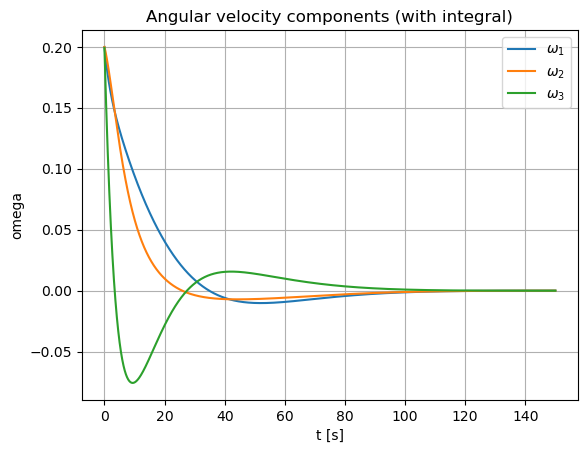

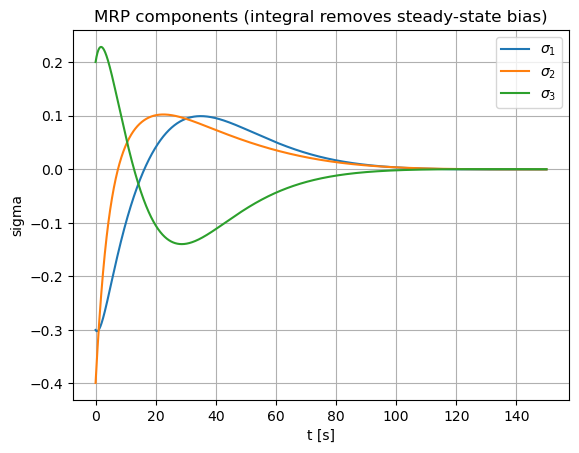

In [7]:
# Time
dt = 0.01
T  = 150.0
t  = np.arange(0, T, dt)
N  = len(t)

# System parameters
I = np.diag([10.0, 10.0, 10.0])
K = 1.0
P = np.diag([3.0, 3.0, 3.0])
K_I = np.diag([0.01, 0.01, 0.01])

# Constant disturbance torque
DeltaL = np.array([0.05, 0.10, -0.10])

# Initial condition (match slide)
sigma = np.array([-0.3, -0.4, 0.2])
omega = np.array([0.2, 0.2, 0.2])
z     = np.zeros(3)

# Logs
sigma_hist = np.zeros((N,3))
omega_hist = np.zeros((N,3))
z_hist     = np.zeros((N,3))

for k in range(N):

    domega = omega  # regulation case

    omega_tilde = ak.skew_symmetric(omega)

    # Integral-augmented controller
    u = -K*sigma - P@domega - P@K_I@z + omega_tilde@(I@omega)

    # True dynamics include disturbance
    wdot = np.linalg.solve(I, -omega_tilde@(I@omega) + u + DeltaL)

    sigmadot = 0.25 * ak.Bmat_MRP(sigma) @ omega
    zdot     = sigma

    # Euler integration
    omega = omega + dt*wdot
    sigma = sigma + dt*sigmadot
    z     = z + dt*zdot

    sigma = ak.MRP_shadow(sigma)

    sigma_hist[k] = sigma
    omega_hist[k] = omega
    z_hist[k]     = z

# Plot omega components
plt.figure()
plt.plot(t, omega_hist[:,0], label=r'$\omega_1$')
plt.plot(t, omega_hist[:,1], label=r'$\omega_2$')
plt.plot(t, omega_hist[:,2], label=r'$\omega_3$')
plt.title("Angular velocity components (with integral)")
plt.xlabel("t [s]")
plt.ylabel("omega")
plt.grid(True)
plt.legend()

# Plot sigma components
plt.figure()
plt.plot(t, sigma_hist[:,0], label=r'$\sigma_1$')
plt.plot(t, sigma_hist[:,1], label=r'$\sigma_2$')
plt.plot(t, sigma_hist[:,2], label=r'$\sigma_3$')
plt.title("MRP components (integral removes steady-state bias)")
plt.xlabel("t [s]")
plt.ylabel("sigma")
plt.grid(True)
plt.legend()

plt.show()

# 3.7 - Feedback Gain Selection via Linearization

Section 3.7 addresses a practical question: the Lyapunov analysis guarantees stability, but how should the gains $K$ and $[P]$ be chosen to obtain a desired transient response?

To gain design intuition, we linearize the closed-loop dynamics about the equilibrium

$$
\boldsymbol{\sigma}=\mathbf{0}, 
\qquad 
\delta\boldsymbol{\omega}=\mathbf{0}.
$$

For small attitude errors, the MRP kinematics simplify:

$$
\dot{\boldsymbol{\sigma}} =
\frac{1}{4} B(\boldsymbol{\sigma}) \delta\boldsymbol{\omega}
\quad \Rightarrow \quad
\dot{\boldsymbol{\sigma}}
\approx
\frac{1}{4}\delta\boldsymbol{\omega}.
$$

The nonlinear closed-loop dynamics reduce to

$$
[I]\dot{\delta\boldsymbol{\omega}}
+ [P]\delta\boldsymbol{\omega}
+ K\boldsymbol{\sigma} =
\mathbf{0}.
$$

Differentiating the linearized kinematics,

$$
\ddot{\boldsymbol{\sigma}}
\approx
\frac{1}{4}\dot{\delta\boldsymbol{\omega}},
$$

and substituting into the dynamics yields

$$
[I]\ddot{\boldsymbol{\sigma}}
+ [P]\dot{\boldsymbol{\sigma}}
+ \frac{K}{4}\boldsymbol{\sigma} =
\mathbf{0}.
$$

If the body frame is aligned with principal axes,

$$
[I]=\text{diag}(I_1,I_2,I_3),
$$

the system decouples into three independent scalar equations:

$$
I_i \ddot{\sigma}_i + P_i \dot{\sigma}_i + \frac{K}{4}\sigma_i = 0, \qquad i=1,2,3.
$$

Each axis behaves like a classical second-order system with characteristic equation

$$
I_i \lambda^2 + P_i \lambda + \frac{K}{4} = 0.
$$

The roots are

$$
\lambda_i = -\frac{P_i}{2I_i} \pm\frac{1}{2I_i} \sqrt{P_i^2 - K I_i}.
$$

From this form, we identify the standard second-order parameters.

Natural frequency:

$$
\omega_{n,i} = \sqrt{\frac{K}{4I_i}}.
$$

Damping ratio:

$$
\zeta_i = \frac{P_i}{2\sqrt{K I_i}}.
$$

Time decay constant:

$$
T_i = \frac{2I_i}{P_i}.
$$

Damped natural frequency (underdamped case, $P_i^2 < K I_i$):

$$
\omega_{d,i} = \frac{1}{2I_i} \sqrt{K I_i - P_i^2}.
$$

System behavior classification:

• $P_i^2 < K I_i$ → underdamped (complex roots)  
• $P_i^2 = K I_i$ → critically damped  
• $P_i^2 > K I_i$ → overdamped  

Design interpretation:

Increasing $K$ increases the natural frequency and speeds up the response.  
Increasing $P_i$ increases damping and reduces oscillation.  
Critical damping occurs when $P_i^2 = K I_i$.

Although derived from a linearization, these relationships accurately predict transient behavior near the equilibrium. Therefore, gains can be selected using classical second-order intuition, then validated in full nonlinear simulation.

Predicted natural frequency: 0.31622776601683794
Predicted damping ratio: 0.23717082451262844
Predicted time constant: 6.666666666666667


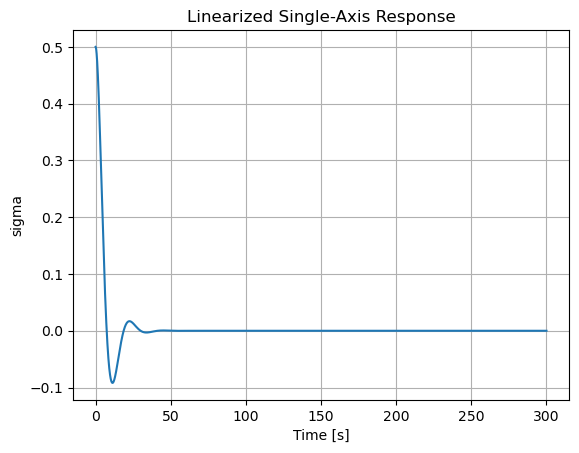

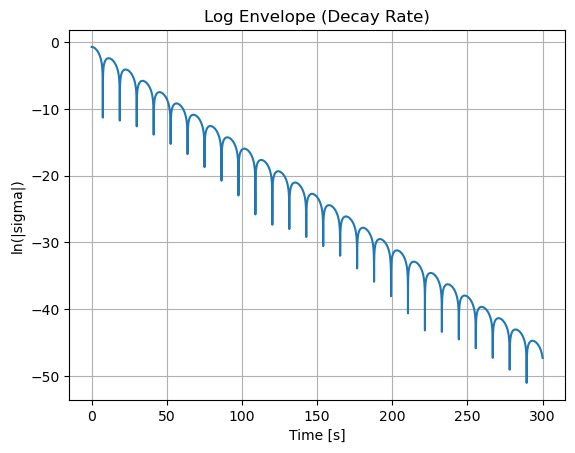

In [8]:
# Parameters (single axis)
I = 10.0
K = 4.0
P = 3.0   # try changing this to see overdamped/underdamped behavior

# Derived quantities (from theory)
omega_n = np.sqrt(K/(4*I))
zeta = P/(2*np.sqrt(K*I))
T_pred = 2*I/P

print("Predicted natural frequency:", omega_n)
print("Predicted damping ratio:", zeta)
print("Predicted time constant:", T_pred)

# Time
dt = 0.01
T  = 300
t  = np.arange(0, T, dt)

# State variables
sigma = 0.5
sigma_dot = 0.0

sigma_hist = []

for _ in t:
    
    # Second-order ODE rewritten as first-order system
    sigma_ddot = -(P/I)*sigma_dot - (K/(4*I))*sigma
    
    sigma_dot += dt*sigma_ddot
    sigma += dt*sigma_dot
    
    sigma_hist.append(sigma)

sigma_hist = np.array(sigma_hist)

# Plot response
plt.figure()
plt.plot(t, sigma_hist)
plt.xlabel("Time [s]")
plt.ylabel("sigma")
plt.title("Linearized Single-Axis Response")
plt.grid(True)
plt.show()

# Plot log envelope to check exponential decay
plt.figure()
plt.plot(t, np.log(np.abs(sigma_hist)))
plt.xlabel("Time [s]")
plt.ylabel("ln(|sigma|)")
plt.title("Log Envelope (Decay Rate)")
plt.grid(True)
plt.show()

# 3.8 - Simulation Toolkit

Section 3.8 transitions from theoretical analysis to numerical verification.

Sections 3.1–3.7 established stability, asymptotic convergence, disturbance rejection, and gain selection using Lyapunov theory and linearization. While these results guarantee behavior analytically, they must be validated in a numerical simulation to observe transient response, nonlinear effects, and large-angle motion.

To support this validation, a modular simulation architecture is implemented.

The architecture deliberately separates:

• Rigid-body dynamics  
• Control law computation  
• Numerical integration  
• Scenario configuration (initial conditions, gains, disturbances)  

This separation serves several purposes.

First, it preserves transparency between theory and implementation. The control law derived in the Lyapunov analysis appears explicitly in code, rather than being embedded inside the dynamics.

Second, it enables reuse. Different controllers (PD, integral, disturbance rejection variants) can be tested without rewriting the rigid-body equations.

Third, it isolates numerical effects. The integration method can be modified independently of the control design.

The closed-loop simulation follows a standard structure at each time step:

1. Compute the control torque from the current state.  
2. Evaluate the rigid-body rotational dynamics.  
3. Propagate the state using numerical integration.  
4. Apply MRP shadow switching when required.  
5. Store state and control histories for analysis.  

This structure mirrors the block diagram of a physical spacecraft attitude control system and ensures that theoretical assumptions remain visible and testable in simulation.

## 3.8.1 - rk4_step

**Context:**  
The closed-loop attitude dynamics form a nonlinear first-order ordinary differential equation

$$
\dot{x} = f(t, x),
$$

where the state vector includes attitude parameters and angular velocity.  
An analytical solution is not available, so numerical integration is required.

**Purpose:**  
`rk4_step` advances the state by one timestep using the classical 4th-order Runge–Kutta (RK4) method.

**Why RK4?**

• Higher accuracy than Euler integration for the same timestep  
• Good balance between computational cost and numerical stability  
• Widely used standard for nonlinear dynamics simulation  
• Keeps control law and plant model independent of integration method  

**Role in Simulation Architecture:**

• Accepts a generic RHS function `f(t, x, ...)`  
• Does not contain control logic or plant equations  
• Can integrate any dynamical system with the same interface  
• Allows easy replacement with other integrators if needed  

This function isolates numerical integration from system modeling, preserving modularity and transparency in the closed-loop simulation.

In [9]:
def rk4_step(f, t, x, dt, *args, **kwargs):
    """
    Advance one timestep using classical 4th-order Runge–Kutta (RK4).
    
    Parameters
    ----------
    f : callable
        RHS function with signature f(t, x, *args, **kwargs) -> xdot.
    t : float
        Current time.
    x : np.ndarray
        Current state vector.
    dt : float
        Timestep size.
    *args, **kwargs
        Extra arguments passed through to `f`.
    
    Returns
    -------
    x_next : np.ndarray
        State advanced by one RK4 step of size `dt`.
    """
    k1 = f(t, x, *args, **kwargs)
    k2 = f(t + 0.5*dt, x + 0.5*dt*k1, *args, **kwargs)
    k3 = f(t + 0.5*dt, x + 0.5*dt*k2, *args, **kwargs)
    k4 = f(t + dt, x + dt*k3, *args, **kwargs)
    x_next = x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return x_next


## 3.8.2 - mrp_shadow & mrp_compose

**Context:**  
Modified Rodrigues Parameters (MRPs) provide a minimal three-parameter representation of attitude. However:

• MRPs are not globally unique  
• They become ill-conditioned when $\|\boldsymbol{\sigma}\| > 1$  
• Attitude error computation requires nonlinear composition rules  

These helper functions enforce correct geometric behavior of MRPs in simulation.

**Function: `mrp_shadow`**

**Purpose:**  
Ensures the MRP vector remains inside the principal region

$$
\boldsymbol{\sigma}^T \boldsymbol{\sigma} \le 1.
$$

If

$$
\|\boldsymbol{\sigma}\| > 1,
$$

the shadow transformation

$$
\boldsymbol{\sigma}^S = -\frac{\boldsymbol{\sigma}}{\boldsymbol{\sigma}^T \boldsymbol{\sigma}}
$$

is applied.

**Why this is necessary:**

• Prevents numerical blow-up near the switching surface  
• Maintains shortest-rotation representation  
• Preserves Lyapunov function continuity (Section 3.3)  
• Enables almost-global stability in simulation  

This enforces the hybrid switching behavior assumed in the theoretical proof.


In [10]:
def mrp_shadow(sigma: np.ndarray) -> np.ndarray:
    """
    Apply MRP shadow set if ||sigma|| > 1.
    Keeps MRPs numerically well-conditioned.
    """
    s2 = float(sigma @ sigma)
    if s2 > 1.0:
        return -sigma / s2
    return sigma

**Function: `mrp_compose`**

**Purpose:**  
Implements nonlinear MRP composition rules for:

• Successive rotations (`mode="add"`)  
• Relative attitude computation (`mode="sub"`)  

MRPs do not add linearly. Composition follows a rational nonlinear formula derived from quaternion algebra.

**Why this is necessary:**

• Attitude error must be computed using proper rotation composition  
• Subtraction of MRPs directly is incorrect  
• Ensures consistency with SO(3) geometry  
• Keeps control law aligned with theoretical derivations  

The function returns a shadow-corrected result to guarantee numerical conditioning.

In [11]:
def mrp_compose(s1, s2, mode="add"):
    """
    mrp_compose(s1, s2, mode)

    Q = mrp_compose(s1, s2, mode) provides the MRP vector corresponding to:

        mode = "add" :
            successive rotations s1 followed by s2

        mode = "sub" :
            relative rotation from s2 to s1

    This is a unified implementation of addMRP and subMRP.
    """

    # Ensure column-like vectors (but works with 1D arrays)
    s1 = np.asarray(s1, dtype=float).reshape(3,)
    s2 = np.asarray(s2, dtype=float).reshape(3,)

    s1_sq = np.dot(s1, s1)
    s2_sq = np.dot(s2, s2)
    s1_dot_s2 = np.dot(s1, s2)
    s1_cross_s2 = np.cross(s1, s2)

    if mode == "add":
        # --- MRP addition (successive rotations) ---
        q = ((1 - s1_sq) * s2 + (1 - s2_sq) * s1 + 2 * s1_cross_s2)
        q = q / (1 + s1_sq * s2_sq - 2 * s1_dot_s2)

    elif mode == "sub":
        # --- MRP subtraction (relative attitude) ---
        q = ((1 - s2_sq) * s1 - (1 - s1_sq) * s2 + 2 * s1_cross_s2)
        q = q / (1 + s1_sq * s2_sq + 2 * s1_dot_s2)

    else:
        raise ValueError("mode must be 'add' or 'sub'")

    return mrp_shadow(q)


**Role in Simulation Architecture:**

• Encapsulates geometric operations separately from dynamics  
• Prevents incorrect linear treatment of attitude parameters  
• Keeps nonlinear rotational algebra isolated and reusable  

Together, these functions ensure that the simulation respects the topology of rotation space while remaining numerically stable.

## 3.8.3 - default_controller_u

**Context:**  
The simulation architecture treats the controller as a plug-in: at every timestep the simulator calls a function with a fixed interface and expects a body-frame torque output,

$$
\boldsymbol{u}_B = \text{controller}(t,\;\text{state},\;\text{ref},\;\text{ctx}).
$$

A “default” controller is useful because it allows the plant and simulator to be developed and tested before the full nonlinear control law is introduced.

**Purpose:**  

- Provide a minimal **always-callable** baseline controller so the simulation loop can run end-to-end.  
- Establish and enforce a consistent controller interface (`t, state, ref, ctx → u_B`).  
- Serve as a reference behavior to compare against more advanced controllers (feedforward, gyro compensation, disturbance rejection, integral terms, etc.).  

**What it computes:**  

- **Attitude error** using MRP composition (geometry-correct error, not subtraction):
  $$
  \boldsymbol{\sigma}_{BR} = \boldsymbol{\sigma}_{BN} \oplus (-\boldsymbol{\sigma}_{RN})
  $$
  implemented via `mrp_compose(..., mode="sub")`.

- **Rate error** in the body frame:
  $$
  \boldsymbol{\omega}_{BR}^B = \boldsymbol{\omega}_{BN}^B - \boldsymbol{\omega}_{RN}^B,
  $$
  where $\boldsymbol{\omega}_{RN}^B$ is obtained by rotating the reference rate from frame $R$ into frame $B$ using
  $$
  [C]_{BR} = [C]_{BN}[C]_{RN}^T.
  $$

**Control law implemented:**  
A baseline PD regulator in MRPs and body rates,

$$
\boldsymbol{u}_B = -[K]\boldsymbol{\sigma}_{BR} - [P]\boldsymbol{\omega}_{BR}^B.
$$

In the default regulator case, the reference is the origin:
$$
\boldsymbol{\sigma}_{RN}=\mathbf{0},\qquad \boldsymbol{\omega}_{RN}^R=\mathbf{0}.
$$

**Why this function exists (architecturally):**  

- Lets you validate the simulator plumbing (state passing, reference handling, logging) with a controller that is simple and predictable.  
- Ensures attitude errors are computed correctly on $SO(3)$ via MRP composition.  
- Supports both scalar gains and per-axis gains, which matches the gain-selection discussion in Section 3.7.  
- Provides a stable baseline before switching to the full nonlinear CC laws used in the later sections.

In [12]:
def default_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    Default attitude controller (baseline PD in MRPs + body rates).

    Purpose
    -------
    This is a minimal, *always-callable* controller that establishes the
    controller interface used throughout the Coursera notebooks:

        u_B = controller(t, state, ref, ctx)

    It also provides a sensible baseline behavior before you introduce the
    full CC laws (feedforward, gyro compensation, disturbance terms, etc.).

    Control Law
    -----------
    A simple PD regulator about the reference attitude/rate:

        u_B = -K * sigma_BR - P * omega_BR_B

    Regulator case (default):
        sigma_RN = 0
        omega_RN_R = 0

    Tracking case (optional):
        Provide sigma_RN and omega_RN_R in `ref`. This controller will compute
        sigma_BR and omega_BR_B and regulate to the reference.

    State
    -----
    state["sigma_BN"]   : MRPs of body B relative to inertial N
    state["omega_BN_B"] : angular rate of B relative to N expressed in B

    Reference (optional)
    --------------------
    ref["sigma_RN"]   : MRPs of reference R relative to N (default zeros)
    ref["omega_RN_R"] : angular rate of R relative to N expressed in R (default zeros)

    Context
    -------
    ctx["ctl"]["K"] : attitude gain (scalar) OR ctx["ctl"]["K_vec"] : 3-vector gains
    ctx["ctl"]["P"] : rate gain (scalar)    OR ctx["ctl"]["P_vec"] : 3-vector gains

    Returns
    -------
    u_B : control torque expressed in body frame B
    """

    # --- Unpack state ---
    sigma_BN = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega_BN_B = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)

    # --- Unpack reference with defaults (regulator) ---
    sigma_RN = np.asarray(ref.get("sigma_RN", np.zeros(3)), dtype=float).reshape(3,)
    omega_RN_R = np.asarray(ref.get("omega_RN_R", np.zeros(3)), dtype=float).reshape(3,)

    # --- Gains (support scalar or per-axis vector) ---
    ctl = ctx.get("ctl", {})
    if "K_vec" in ctl:
        K = np.asarray(ctl["K_vec"], dtype=float).reshape(3,)
    else:
        K = float(ctl.get("K", 1.0)) * np.ones(3)

    if "P_vec" in ctl:
        P = np.asarray(ctl["P_vec"], dtype=float).reshape(3,)
    else:
        P = float(ctl.get("P", 2.0)) * np.ones(3)

    # --- Attitude error sigma_BR ---
    # Assumes you already have mrp_compose(sigma_BN, sigma_RN, mode="sub")
    # which computes sigma_BR (B relative R).
    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    # --- Rate error omega_BR_B ---
    # We need omega_RN expressed in B to compare with omega_BN_B.
    # This mirrors your CC1 approach and keeps conventions consistent.
    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    omega_RN_B = C_BR @ omega_RN_R
    omega_BR_B = omega_BN_B - omega_RN_B

    # --- PD control torque in B ---
    u_B = -K * sigma_BR - P * omega_BR_B

    return u_B

## 3.8.4 - cc_xdot_mrp

**Context:**  
The simulation architecture separates the controller from the physical spacecraft model.  
`cc_xdot_mrp` represents the **plant only**, i.e., the true rigid-body rotational dynamics.

It defines the continuous-time system

$$
\dot{x} = f(t, x, \boldsymbol{u}_B),
$$

where the state is

$$
x =
\begin{bmatrix}
\boldsymbol{\sigma}_{BN} \\
\boldsymbol{\omega}_{BN}^B
\end{bmatrix}.
$$

No control logic appears in this function.


**Purpose:**  

- Implement the rigid-body rotational equations of motion  
- Provide a clean RHS function compatible with generic integrators  
- Keep spacecraft physics independent of controller structure  


**Rigid-body dynamics implemented:**

Euler’s rotational equation:

$$
[I]\dot{\boldsymbol{\omega}}_{BN}^B = \boldsymbol{u}_B + \boldsymbol{L}_B - \boldsymbol{\omega}_{BN}^B \times \left([I]\boldsymbol{\omega}_{BN}^B\right).
$$

MRP kinematics:

$$
\dot{\boldsymbol{\sigma}}_{BN} =
\frac{1}{4}
B(\boldsymbol{\sigma}_{BN})
\boldsymbol{\omega}_{BN}^B.
$$

These two equations fully define spacecraft rotational motion.


**Design principles enforced by this function:**

• Controller torque $\boldsymbol{u}_B$ is treated as an external input  
• Disturbance torque $\boldsymbol{L}_B$ is injected at the plant level  
• No gain parameters or control decisions appear here  
• MRP shadowing is applied before kinematics to maintain conditioning  


**Architectural role:**

- Represents the “truth model” of the spacecraft  
- Can be reused with different controllers  
- Allows disturbance studies (Section 3.5–3.6) without modifying control code  
- Keeps numerical integration independent of physical modeling  

This function is the physical core of the simulation.  
Everything else — controller, integrator, reference generation — interacts with it through well-defined interfaces.

In [13]:
def cc_xdot_mrp(
    t: float,
    x: np.ndarray,
    u_B: np.ndarray,
    ctx: dict,
) -> np.ndarray:
    """
    Rigid-body MRP attitude dynamics (plant model only).

    This function defines the continuous-time plant dynamics:

        x_dot = f(t, x, u)

    where the state is:
        x = [ sigma_BN (3), omega_BN_B (3) ]

    and the control input is:
        u_B = body control torque expressed in frame B.

    No controller logic is included here. This function represents
    the physical spacecraft rotational dynamics only.

    Parameters
    ----------
    t : float
        Current simulation time [s]. (Not explicitly used here but
        included for compatibility with generic integrators.)

    x : np.ndarray, shape (6,)
        State vector:
            x[0:3] = sigma_BN     (MRPs of body B relative to inertial N)
            x[3:6] = omega_BN_B   (angular rate of B wrt N, expressed in B) [rad/s]

    u_B : np.ndarray, shape (3,)
        Control torque applied in body frame B [N*m].

    ctx : dict
        Context dictionary containing spacecraft parameters under
        the "sc" namespace:
            ctx["sc"]["I"]   : inertia matrix in body frame B (3x3)
            ctx["sc"]["L_B"] : external disturbance torque applied
                            to the plant (3,) [N*m] (default zero)

    Returns
    -------
    xdot : np.ndarray, shape (6,)
        Time derivative of the state vector:
            xdot[0:3] = sigma_dot   (MRP kinematics)
            xdot[3:6] = omega_dot_B (rigid-body rotational dynamics)
    """
    x = np.asarray(x, dtype=float).reshape(-1,)
    if x.size != 6:
        raise ValueError(f"cc_xdot expects state length 6, got {x.size}")

    # ---- unpack state ----
    sigma_BN = ak.MRP_shadow(x[0:3])
    omega_BN_B = x[3:6]

    # ---- input torque ----
    u_B = np.asarray(u_B, dtype=float).reshape(3,)

    # ---- plant parameters (spacecraft truth only) ----
    sc = ctx["sc"]
    I = np.asarray(sc["I"], dtype=float).reshape(3, 3)
    L_B = np.asarray(sc.get("L_B", np.zeros(3)), dtype=float).reshape(3,)

    # ---- rigid-body rotational dynamics ----
    # I * omega_dot = u + L - omega x (I omega)
    omega_dot_B = np.linalg.solve(I, u_B + L_B - np.cross(omega_BN_B, I @ omega_BN_B))

    # ---- MRP kinematics ----
    # sigma_dot = 0.25 * B(sigma) * omega
    sigma_dot = 0.25 * (ak.Bmat_MRP(sigma_BN) @ omega_BN_B)
    
    # Pack state derivative
    xdot = np.hstack((sigma_dot, omega_dot_B))
    
    return xdot


## 3.8.5 - simulate_CC

**Context:**  
The earlier sections derived nonlinear attitude control laws and proved stability properties. `simulate_CC` is the numerical harness that reproduces the Coursera concept-check simulations by combining:

- a controller (plug-in)  
- a plant model (rigid-body dynamics)  
- a fixed-step RK4 integrator  
- reference generation (tracking or regulation)  
- logging and grading-style outputs  

**Purpose:**  

- Provide a single, reusable entry point for running closed-loop attitude simulations  
- Enforce a consistent interface between controller and plant  
- Reproduce concept-check assumptions exactly (especially the controller sampling rule)  
- Log all key signals needed for analysis: states, errors, control, and integral quantities  

**Key design choice — ZOH semantics (grading-critical):**  
The controller is evaluated once per step at time $t_k$ and the resulting torque is held constant during the RK4 sub-stages:

- compute $\boldsymbol{u}_B(t_k)$ once  
- use this same $\boldsymbol{u}_B$ for $k_1, k_2, k_3, k_4$  
- propagate $x_{k+1}$ using RK4 with constant input  

This matches a realistic digital control implementation: a discrete controller driving a continuous plant under a zero-order hold.

**Plant/controller separation enforced by function signatures:**  

- Controller interface:
  $$
  \boldsymbol{u}_B = \text{controller}(t,\;\text{state},\;\text{ref},\;\text{ctx})
  $$
- Plant interface:
  $$
  \dot{x} = \text{plant}(t,\;x,\;\boldsymbol{u}_B,\;\text{ctx})
  $$

The plant contains only spacecraft physics, while the controller contains only control logic.

**Reference generation (concept-check compatibility):**  

- `mode="tracking"` generates $\boldsymbol{\sigma}_{RN}(t)$ and computes $\boldsymbol{\omega}_{RN}^R(t)$ via
  $$
  \boldsymbol{\omega}_{RN}^R = 4\,B^{-1}(\boldsymbol{\sigma}_{RN})\,\dot{\boldsymbol{\sigma}}_{RN}.
  $$
- `mode="regulator"` sets the reference to zero.

This keeps reference kinematics consistent with the MRP definitions used in the theory.

**Error computation and logging (what gets stored):**  

- $\boldsymbol{\sigma}_{BN}$, $\boldsymbol{\omega}_{BN}^B$ (state)  
- $\boldsymbol{\sigma}_{BR}$, $\boldsymbol{\omega}_{BR}^B$ (tracking error)  
- $\boldsymbol{u}_B$ (control torque history)  
- $\boldsymbol{z}$-related quantities for integral analysis  
- norms required for concept-check style reporting at a specified time  

**Integral bookkeeping (controller memory in `ctx["ctl"]`):**  
Integral action is handled as persistent controller memory inside the context dictionary. The simulator updates

$$
\boldsymbol{\eta}(t) = \int \boldsymbol{\sigma}_{BR}(t)\,dt
$$

using a simple discrete update, and then constructs the composite quantity

$$
\boldsymbol{z} = K\boldsymbol{\eta} + [I]\big(\boldsymbol{\omega}_{BR}^B - \boldsymbol{\omega}_{BR0}^B\big),
$$

to match the structure introduced in the integral-feedback analysis.

**Why this function exists (architecturally):**  

- Makes the simulation reusable: swap controllers and plants without rewriting the loop  
- Makes assumptions explicit: sampling, integration, shadow switching, disturbances  
- Preserves transparency: theory-derived signals ($\sigma_{BR}$, $\omega_{BR}$, $z$) are computed and logged explicitly  
- Produces a single `results` dictionary that is easy to post-process and compare across test cases  

In [14]:
def simulate_CC(
    controller=default_controller_u,
    plant=cc_xdot_mrp,
    spacecraft_params: dict | None = None,
    controller_params: dict | None = None,
    simulation_config: dict | None = None,
    reference_config: dict | None = None,
    grading_config: dict | None = None,
):
    """
    RK4 simulator harness for Coursera attitude concept checks.

    This simulator integrates the 6-state rigid-body attitude dynamics:
        x = [sigma_BN (MRP), omega_BN_B]

    using a fixed-step RK4 integrator.

    ZOH semantics (grading-critical):
    - The controller is evaluated once per outer step at time t_k.
    - The resulting u_B is held constant during the RK4 sub-stages for that step.
    - This is implemented by passing u_B into the plant as a constant input for the RK4 step.

    Parameters
    ----------
    controller : callable
        Control law with signature:
            u_B = controller(t, state, ref_k, ctx)

        where:
            state : dict with keys {"sigma_BN", "omega_BN_B"}
            ref_k : dict with keys {"sigma_RN", "omega_RN_R", "omega_dot_RN_R"}
            ctx   : dict with namespaces:
                    ctx["sc"]  spacecraft parameters (truth)
                    ctx["ctl"] controller parameters + memory

    plant : callable
        Plant state derivative with signature:
            xdot = plant(t, x, u_B, ctx)

        Note:
        - plant is purely physics. It does not call the controller.
        - plant should read only spacecraft truth parameters from ctx["sc"].

    spacecraft_params : dict
        Spacecraft physical parameters (truth).
        Typical keys:
            "I"   (3x3): inertia matrix in B
            "L_B" (3,): external disturbance torque applied to the plant

    controller_params : dict
        Controller parameters and controller memory.
        Typical keys:
            "K", "P", "Ki"
            "modelL_B" (3,)  (optional model estimate; not used by all controllers)
            "integral_sigma_BR" (3,) (controller memory)
            "omega_BR0_B" (3,)       (controller memory / initialization)

    simulation_config : dict
        Simulation setup:
            {"t0": float, "tf": float, "dt": float,
             "sigma0": (3,), "omega0_deg": (3,), "eta0": (3,) optional}

    reference_config : dict
        Reference generation configuration:
            {"mode": "tracking"|"regulator", "f": float}

        For tracking mode, this function generates sigma_RN(t) as in the concept checks.

    grading_config : dict
        Coursera helper for printing a norm at a chosen time:
            {"time_s": float, "quantity": "sigma_BR"|"sigma_BN"}

    Returns
    -------
    results : dict
        Time histories and key logged quantities.
    """
    # ---- Default dictionaries ----
    if spacecraft_params is None:
        spacecraft_params = {}
    if controller_params is None:
        controller_params = {}
    if simulation_config is None:
        simulation_config = {}
    if reference_config is None:
        reference_config = {}
    if grading_config is None:
        grading_config = {}

    spacecraft_params = dict(spacecraft_params)
    controller_params = dict(controller_params)
    simulation_config = dict(simulation_config)
    reference_config = dict(reference_config)
    grading_config = dict(grading_config)

    # ---- Time setup ----
    t0 = float(simulation_config.get("t0", 0.0))
    tf = float(simulation_config.get("tf", 120.0))
    dt = float(simulation_config.get("dt", 0.01))

    t_hist = np.arange(t0, tf + dt, dt)
    N = t_hist.size

    # ---- Spacecraft parameters ----
    if "I" not in spacecraft_params:
        spacecraft_params["I"] = np.diag([100.0, 75.0, 80.0])
    spacecraft_params["I"] = np.asarray(spacecraft_params["I"], dtype=float).reshape(3, 3)

    spacecraft_params.setdefault("L_B", np.zeros(3))
    spacecraft_params["L_B"] = np.asarray(spacecraft_params["L_B"], dtype=float).reshape(3,)

    # ---- Controller parameters ----
    controller_params.setdefault("K", 5.0)
    controller_params.setdefault("P", 10.0)
    controller_params.setdefault("Ki", 0.0)
    controller_params.setdefault("modelL_B", np.zeros(3))
    controller_params["modelL_B"] = np.asarray(controller_params["modelL_B"], dtype=float).reshape(3,)

    # ---- Initial conditions ----
    sigma0 = np.asarray(simulation_config.get("sigma0", [0.1, 0.2, -0.1]), dtype=float).reshape(3,)
    omega0_deg = np.asarray(simulation_config.get("omega0_deg", [30.0, 10.0, -20.0]), dtype=float).reshape(3,)
    omega0 = np.deg2rad(omega0_deg)

    x = np.hstack((sigma0, omega0))
    x[0:3] = mrp_shadow(x[0:3])

    # ---- Integral memory ----
    eta0 = simulation_config.get("eta0", None)
    if eta0 is None:
        controller_params.setdefault("integral_sigma_BR", np.zeros(3))
    else:
        controller_params["integral_sigma_BR"] = np.asarray(eta0, dtype=float).reshape(3,)

    # ---- Reference generation ----
    ref_mode = str(reference_config.get("mode", "tracking")).lower()
    f = float(reference_config.get("f", 0.05))

    sigma_RN_hist = np.zeros((N, 3))
    omega_RN_R_hist = np.zeros((N, 3))
    omega_dot_RN_R_hist = np.zeros((N, 3))

    if ref_mode == "tracking":
        for k, tt in enumerate(t_hist):
            st = np.sin(f * tt)
            ct = np.cos(f * tt)

            sigma_RN = np.array([0.2 * st, 0.3 * ct, -0.3 * st])
            sigma_RN_dot = np.array([0.2 * f * ct, -0.3 * f * st, -0.3 * f * ct])

            sigma_RN_hist[k] = sigma_RN
            omega_RN_R_hist[k] = 4.0 * ak.BInvmat_MRP(sigma_RN) @ sigma_RN_dot

        omega_dot_RN_R_hist[:] = np.gradient(omega_RN_R_hist, t_hist, axis=0)

    elif ref_mode == "regulator":
        # Leave reference histories as zeros
        pass
    else:
        raise ValueError("reference_config['mode'] must be 'tracking' or 'regulator'")

    # ---- Grading setup ----
    report_time_s = float(grading_config.get("time_s", 40.0))
    report_quantity = str(grading_config.get("quantity", "sigma_BR"))

    # ---- Initialize omega_BR0_B if needed ----
    if "omega_BR0_B" not in controller_params:
        sigma_BN0 = x[0:3]
        omega_BN_B0 = x[3:6]

        sigma_RN0 = sigma_RN_hist[0]
        omega_RN_R0 = omega_RN_R_hist[0]

        C_BN0 = ak.MRP_to_DCM(sigma_BN0)
        C_RN0 = ak.MRP_to_DCM(sigma_RN0)
        C_BR0 = C_BN0 @ C_RN0.T

        omega_RN_B0 = C_BR0 @ omega_RN_R0
        controller_params["omega_BR0_B"] = omega_BN_B0 - omega_RN_B0

    # ---- Storage ----
    x_hist = np.zeros((N, 6))
    u_hist = np.zeros((N, 3))

    sigma_BN_hist = np.zeros((N, 3))
    omega_BN_B_hist = np.zeros((N, 3))

    sigma_BR_hist = np.zeros((N, 3))
    omega_BR_hist = np.zeros((N, 3))
    sigma_norm_hist = np.zeros(N)
    z_hist = np.zeros((N, 3))

    # ---- Namespaced context ----
    ctx = {
        "sc": spacecraft_params,
        "ctl": controller_params,
    }
    
    # Progress bar for simulation loop
    pbar = tqdm(
        total=tf - t0,
        desc="simulate_CC",
        unit="sim_s",
        dynamic_ncols=True,
        bar_format="{l_bar}{bar}| {n:.2f}/{total:.2f} {unit} [{elapsed}<{remaining}, {rate_fmt}]",
        )

    t_wall_start = time.perf_counter()

    try:
        # ---- Simulation loop ----
        for k, tt in enumerate(t_hist):

            sigma_BN = x[0:3]
            omega_BN_B = x[3:6]

            sigma_BN_hist[k] = sigma_BN
            omega_BN_B_hist[k] = omega_BN_B

            state = {
                "sigma_BN": sigma_BN,
                "omega_BN_B": omega_BN_B,
            }

            ref_k = {
                "sigma_RN": sigma_RN_hist[k],
                "omega_RN_R": omega_RN_R_hist[k],
                "omega_dot_RN_R": omega_dot_RN_R_hist[k],
            }

            # ---- Compute tracking errors (in B) ----
            C_BN = ak.MRP_to_DCM(sigma_BN)
            C_RN = ak.MRP_to_DCM(ref_k["sigma_RN"])
            C_BR = C_BN @ C_RN.T

            sigma_BR = ak.DCM_to_MRP(C_BR)
            omega_BR_B = omega_BN_B - C_BR @ ref_k["omega_RN_R"]

            # ---- Update integral state (single owner: ctx["ctl"]) ----
            ctx["ctl"]["integral_sigma_BR"] += dt * sigma_BR

            # ---- Log z quantity ----
            eta = ctx["ctl"]["integral_sigma_BR"]
            omega_BR0_B = ctx["ctl"]["omega_BR0_B"]
            z = ctx["ctl"]["K"] * eta + ctx["sc"]["I"] @ (omega_BR_B - omega_BR0_B)
            z_hist[k] = z

            # ---- Store error histories ----
            sigma_BR_hist[k] = sigma_BR
            omega_BR_hist[k] = omega_BR_B
            sigma_norm_hist[k] = (
                np.linalg.norm(sigma_BN)
                if report_quantity == "sigma_BN"
                else np.linalg.norm(sigma_BR)
            )

            # ---- Sample controller once per step (ZOH) ----
            u_B = controller(tt, state, ref_k, ctx)
            u_hist[k] = u_B

            x_hist[k] = x

            # ---- Integrate plant with held control ----
            if k < N - 1:
                x_next = rk4_step(
                    plant,
                    tt,
                    x,
                    dt,
                    u_B,
                    ctx,
                )
                x_next[0:3] = mrp_shadow(x_next[0:3])
                x = x_next
                pbar.update(dt)
    finally:
        pbar.close()
    
    t_wall_end = time.perf_counter()
    wall_time = t_wall_end - t_wall_start
    sim_time = tf - t0
    speed = sim_time / wall_time
    print(f"simulate_CC completed in {wall_time:.3f}s ({speed:.2f}× real-time, {speed:.2f} sim_s/s)")

    # ---- Grading output ----
    idx = np.argmin(np.abs(t_hist - report_time_s))
    label = "sigma_BN" if report_quantity == "sigma_BN" else "sigma_BR"
    print(f"CC: norm({label}) at t={t_hist[idx]:.3f} s = {sigma_norm_hist[idx]:.15f}")

    results = {
        "t": t_hist,
        "x": x_hist,
        "sigma_BN": sigma_BN_hist,
        "omega_BN_B": omega_BN_B_hist,
        "sigma_BR": sigma_BR_hist,
        "omega_BR_B": omega_BR_hist,
        "z": z_hist,
        "u": u_hist,
        "sigma_norm": sigma_norm_hist,
        "params": {
            "spacecraft_params": spacecraft_params,
            "controller_params": controller_params,
        },
        "meta": {
            "simulation_config": {"t0": t0, "tf": tf, "dt": dt},
            "reference_config": {"mode": ref_mode, "f": f},
            "grading_config": {"time_s": report_time_s, "quantity": report_quantity},
        },
    }
    return results

# 3.9 - Numerical Experiments and Concept Check Results

## 3.9.1 - CC1, Q4

In [15]:
def cc1_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    CC1 general attitude tracking controller.

    This implements the globally asymptotically stabilizing control law
    used in both Q4 and Q5.

    Q4 regulator case:
        sigma_RN = 0
        omega_RN_R = 0
        omega_dot_RN_R = 0

    Q5 tracking case:
        sigma_RN, omega_RN_R, omega_dot_RN_R are time varying.

    State
    -----
    state["sigma_BN"]   : MRPs of body B relative to inertial N
    state["omega_BN_B"] : angular rate of B relative to N expressed in B

    Reference
    ---------
    ref["sigma_RN"]       : MRPs of reference R relative to N
    ref["omega_RN_R"]     : angular rate of R relative to N expressed in R
    ref["omega_dot_RN_R"] : angular acceleration of R relative to N expressed in R

    Context
    -------
    ctx["sc"]["I"]   : inertia matrix in body frame B
    ctx["sc"]["L_B"] : external disturbance torque in B, default zero
    ctx["ctl"]["K"]  : attitude gain
    ctx["ctl"]["P"]  : rate gain

    Returns
    -------
    u_B : control torque expressed in body frame B
    """

    # Unpack state
    sigma_BN = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega_BN_B = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)

    # Unpack reference with defaults for regulator case
    sigma_RN = np.asarray(ref.get("sigma_RN", np.zeros(3)), dtype=float).reshape(3,)
    omega_RN_R = np.asarray(ref.get("omega_RN_R", np.zeros(3)), dtype=float).reshape(3,)
    omega_dot_RN_R = np.asarray(ref.get("omega_dot_RN_R", np.zeros(3)), dtype=float).reshape(3,)

    # Unpack context
    I = np.asarray(ctx["sc"]["I"], dtype=float).reshape(3, 3)
    L_B = np.asarray(ctx["sc"].get("L_B", np.zeros(3)), dtype=float).reshape(3,)
    K = float(ctx["ctl"]["K"])
    P = float(ctx["ctl"]["P"])

    # Attitude error sigma_BR
    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    # Relative kinematics in body frame
    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    omega_RN_B = C_BR @ omega_RN_R
    omega_dot_RN_B = C_BR @ omega_dot_RN_R
    omega_BR_B = omega_BN_B - omega_RN_B

    # Feedforward term
    ff = I @ (omega_dot_RN_B - np.cross(omega_BN_B, omega_RN_B))

    # Gyroscopic compensation
    gyro = np.cross(omega_BN_B, I @ omega_BN_B)

    # Control torque
    u_B = -K * sigma_BR - P * omega_BR_B + ff + gyro - L_B

    return u_B

In [16]:
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
L = np.array([0.0, 0.0, 0.0], dtype=float)

sigma0 = np.array([0.1, 0.2, -0.1])
omega0_deg = np.array([30.0, 10.0, -20.0])

spacecraft_params = {
    "I": I,
    "L_B": L,
}

controller_params = {
    "K": K,
    "P": P,
}

simulation_config = {
    "t0": 0.0,
    "tf": 120.0,
    "dt": 0.01,
    "sigma0": sigma0,
    "omega0_deg": omega0_deg,
}

reference_config = {
    "mode": "regulator",  # "tracking" or "regulator"
    "f": 0.0,             # only used for tracking mode
}

grading_config = {
    "time_s": 30.0,
    "quantity": "sigma_BN",  # "sigma_BN" or "sigma_BR"
}


cc1q4_sim_result = simulate_CC(
    controller=cc1_controller_u,
    plant=cc_xdot_mrp,
    spacecraft_params=spacecraft_params,
    controller_params=controller_params,
    simulation_config=simulation_config,
    reference_config=reference_config,
    grading_config=grading_config,
)
cc1q4_sim_result

simulate_CC:   0%|          | 0.00/120.00 sim_s [00:00<?, ?sim_s/s]

simulate_CC completed in 3.746s (32.03× real-time, 32.03 sim_s/s)
CC: norm(sigma_BN) at t=30.000 s = 0.194829038966894


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 1.00000000e-01,  2.00000000e-01, -1.00000000e-01,
          5.23598776e-01,  1.74532925e-01, -3.49065850e-01],
        [ 1.01029530e-01,  2.00444264e-01, -1.01317421e-01,
          5.23025123e-01,  1.74166267e-01, -3.48567474e-01],
        [ 1.02058631e-01,  2.00886939e-01, -1.02634238e-01,
          5.22451530e-01,  1.73799801e-01, -3.48068897e-01],
        ...,
        [-1.02464209e-03,  3.64315683e-05,  5.42430746e-04,
         -3.73760529e-04,  4.62514354e-05, -8.79605486e-05],
        [-1.02557553e-03,  3.65456256e-05,  5.42210391e-04,
         -3.72874447e-04,  4.61654791e-05, -8.81896170e-05],
        [-1.02650675e-03,  3.66594693e-05,  5.41989464e-04,
         -3.71988785e-04,  4.60795614e-05, -8.84182614e-05]]),
 'sigma_BN': array([[ 1.00000000e-01,  2.00000000e-01, -1.00000000e-01],
        [ 1.01029530e-01,  2.00444264e-01, -1.01317421e-01],
        [ 1.02058631

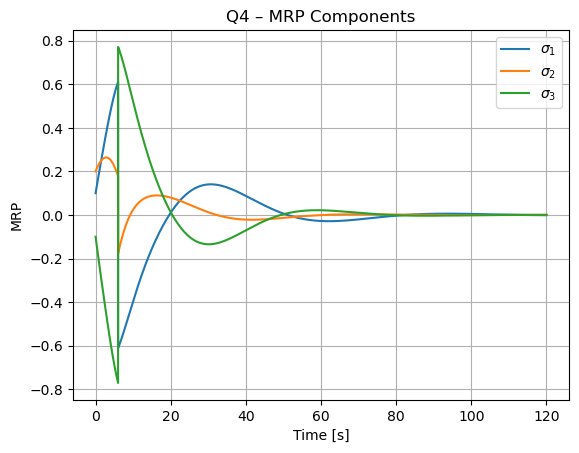

In [17]:
t = cc1q4_sim_result['t']
x = cc1q4_sim_result['x']
u = cc1q4_sim_result['u']

sigma = x[:, 0:3]
omega = x[:, 3:6]
omega_deg = np.rad2deg(omega)

plt.figure()
plt.plot(t, sigma[:, 0], label=r'$\sigma_1$')
plt.plot(t, sigma[:, 1], label=r'$\sigma_2$')
plt.plot(t, sigma[:, 2], label=r'$\sigma_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("Q4 – MRP Components")
plt.legend()
plt.show()

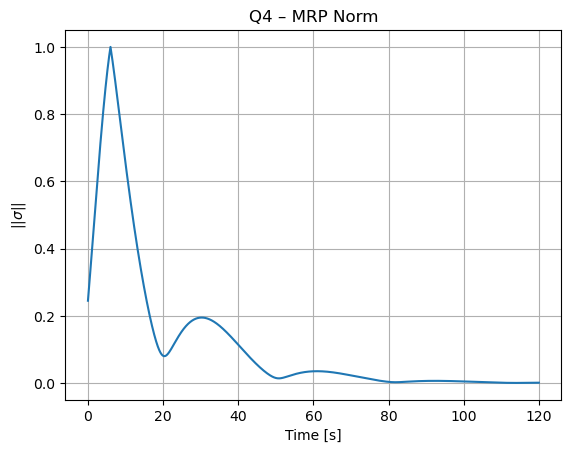

In [18]:
plt.figure()
plt.plot(t, np.linalg.norm(sigma, axis=1))
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel(r"$||\sigma||$")
plt.title("Q4 – MRP Norm")
plt.show()


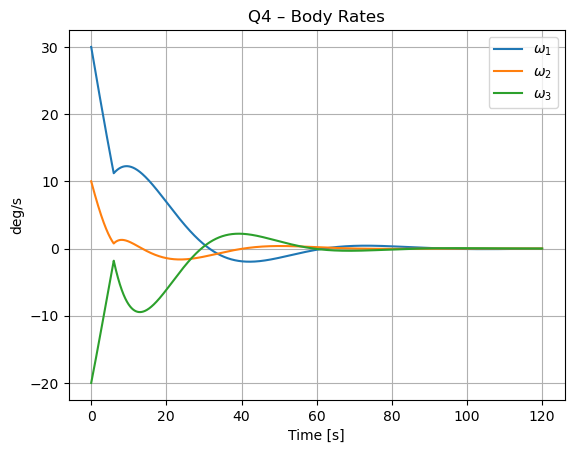

In [19]:
plt.figure()
plt.plot(t, omega_deg[:, 0], label=r'$\omega_1$')
plt.plot(t, omega_deg[:, 1], label=r'$\omega_2$')
plt.plot(t, omega_deg[:, 2], label=r'$\omega_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("deg/s")
plt.title("Q4 – Body Rates")
plt.legend()
plt.show()

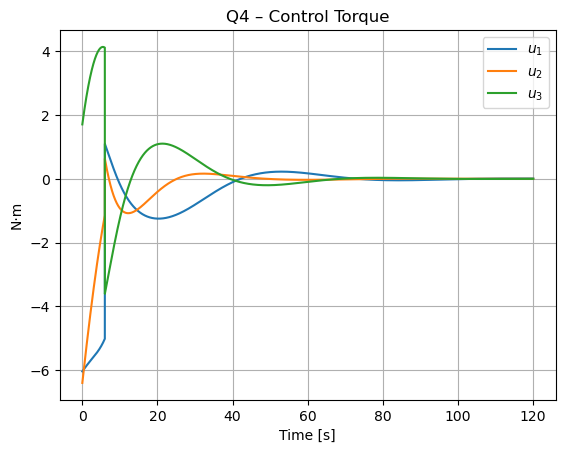

In [20]:
plt.figure()
plt.plot(t, u[:, 0], label=r'$u_1$')
plt.plot(t, u[:, 1], label=r'$u_2$')
plt.plot(t, u[:, 2], label=r'$u_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("N·m")
plt.title("Q4 – Control Torque")
plt.legend()
plt.show()


## 3.9.2 - CC1, Q5

In [21]:
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
L = np.array([0.0, 0.0, 0.0], dtype=float)

sigma0 = np.array([0.1, 0.2, -0.1])
omega0_deg = np.array([30.0, 10.0, -20.0])

spacecraft_params = {
    "I": I,
    "L_B": L,
}

controller_params = {
    "K": K,
    "P": P,
}

simulation_config = {
    "t0": 0.0,
    "tf": 120.0,
    "dt": 0.01,
    "sigma0": sigma0,
    "omega0_deg": omega0_deg,
}


reference_config = {
    "mode": "tracking",
    "f": 0.05,
}

grading_config = {
    "time_s": 40.0,
    "quantity": "sigma_BR",
}

# --- Run ---
cc1q5_sim_result = simulate_CC(
    controller=cc1_controller_u,
    plant=cc_xdot_mrp,
    spacecraft_params=spacecraft_params,
    controller_params=controller_params,
    simulation_config=simulation_config,
    reference_config=reference_config,
    grading_config=grading_config,
)

cc1q5_sim_result

simulate_CC:   0%|          | 0.00/120.00 sim_s [00:00<?, ?sim_s/s]

simulate_CC completed in 3.904s (30.74× real-time, 30.74 sim_s/s)
CC: norm(sigma_BR) at t=40.000 s = 0.158862416280276


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 0.1       ,  0.2       , -0.1       ,  0.52359878,  0.17453293,
         -0.34906585],
        [ 0.10102978,  0.20044435, -0.1013174 ,  0.52317911,  0.17427388,
         -0.348504  ],
        [ 0.10205962,  0.20088729, -0.10263417,  0.52275912,  0.17401595,
         -0.34794191],
        ...,
        [-0.05647211,  0.2880658 ,  0.08413538,  0.06063146,  0.01183167,
         -0.02395752],
        [-0.05637357,  0.2881084 ,  0.08398954,  0.06063558,  0.01181131,
         -0.02396383],
        [-0.05627501,  0.28815093,  0.08384368,  0.0606397 ,  0.01179094,
         -0.02397014]]),
 'sigma_BN': array([[ 0.1       ,  0.2       , -0.1       ],
        [ 0.10102978,  0.20044435, -0.1013174 ],
        [ 0.10205962,  0.20088729, -0.10263417],
        ...,
        [-0.05647211,  0.2880658 ,  0.08413538],
        [-0.05637357,  0.2881084 ,  0.08398954],
        [-0.05627501,  0.288

In [22]:
t = cc1q5_sim_result["t"]
x = cc1q5_sim_result["x"]
sigma_BR = cc1q5_sim_result["sigma_BR"]
omega_BR = cc1q5_sim_result["omega_BR_B"]

sigma_BN = x[:, 0:3]
omega_BN = x[:, 3:6]
omega_BN_deg = np.rad2deg(omega_BN)

omega_BR_deg = np.rad2deg(omega_BR)

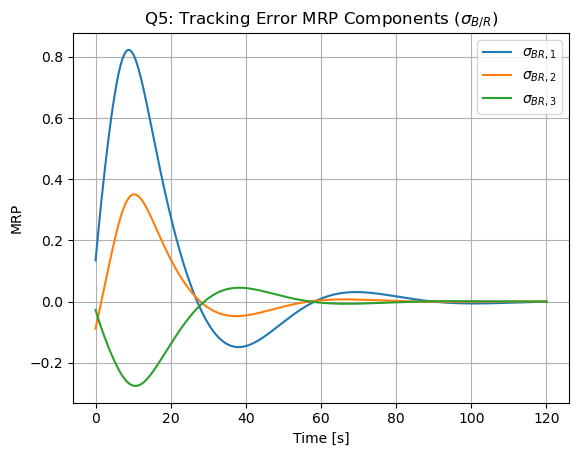

In [23]:
plt.figure()
plt.plot(t, sigma_BR[:, 0], label=r'$\sigma_{BR,1}$')
plt.plot(t, sigma_BR[:, 1], label=r'$\sigma_{BR,2}$')
plt.plot(t, sigma_BR[:, 2], label=r'$\sigma_{BR,3}$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("Q5: Tracking Error MRP Components ($\\sigma_{B/R}$)")
plt.legend()
plt.show()


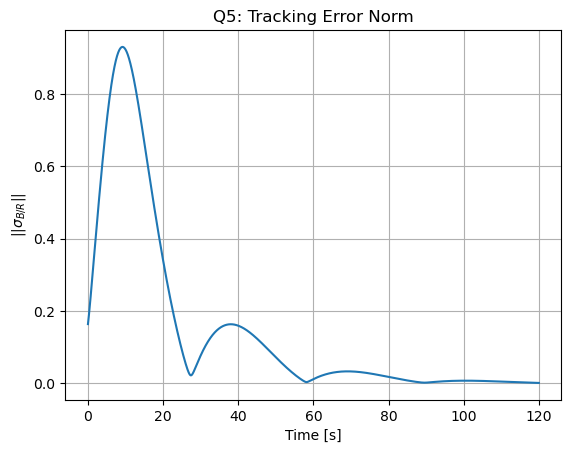

In [24]:
plt.figure()
plt.plot(t, np.linalg.norm(sigma_BR, axis=1))
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel(r"$||\sigma_{B/R}||$")
plt.title("Q5: Tracking Error Norm")
plt.show()


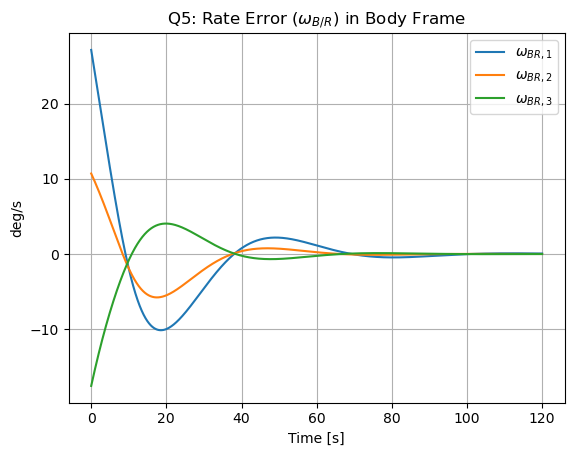

In [25]:
plt.figure()
plt.plot(t, omega_BR_deg[:, 0], label=r'$\omega_{BR,1}$')
plt.plot(t, omega_BR_deg[:, 1], label=r'$\omega_{BR,2}$')
plt.plot(t, omega_BR_deg[:, 2], label=r'$\omega_{BR,3}$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("deg/s")
plt.title("Q5: Rate Error ($\\omega_{B/R}$) in Body Frame")
plt.legend()
plt.show()


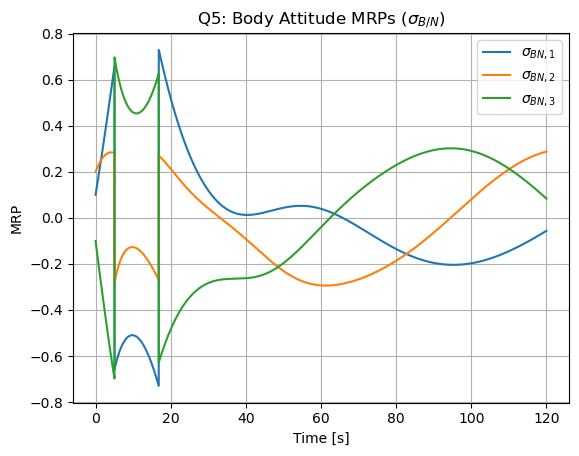

In [26]:
plt.figure()
plt.plot(t, sigma_BN[:, 0], label=r'$\sigma_{BN,1}$')
plt.plot(t, sigma_BN[:, 1], label=r'$\sigma_{BN,2}$')
plt.plot(t, sigma_BN[:, 2], label=r'$\sigma_{BN,3}$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("Q5: Body Attitude MRPs ($\\sigma_{B/N}$)")
plt.legend()
plt.show()


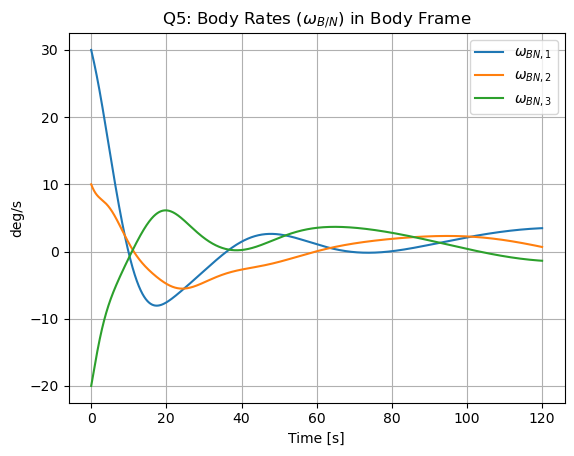

In [27]:
plt.figure()
plt.plot(t, omega_BN_deg[:, 0], label=r'$\omega_{BN,1}$')
plt.plot(t, omega_BN_deg[:, 1], label=r'$\omega_{BN,2}$')
plt.plot(t, omega_BN_deg[:, 2], label=r'$\omega_{BN,3}$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("deg/s")
plt.title("Q5: Body Rates ($\\omega_{B/N}$) in Body Frame")
plt.legend()
plt.show()


## 3.9.3 - CC2, Q5

In [28]:
def cc2_q5_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    CC2/Q5 attitude tracking controller (PD on attitude and rate error).

    Control law:
        u_B = -K * sigma_BR - P * omega_BR_B

    State
    -----
    state["sigma_BN"]   : MRPs of body B relative to inertial N
    state["omega_BN_B"] : angular rate of B relative to N expressed in B

    Reference
    ---------
    ref["sigma_RN"]   : MRPs of reference R relative to N
    ref["omega_RN_R"] : angular rate of R relative to N expressed in R

    Context
    -------
    ctx["ctl"]["K"] : attitude gain
    ctx["ctl"]["P"] : rate gain

    Returns
    -------
    u_B : (3,) control torque expressed in body frame B
    """
    sigma_BN = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega_BN_B = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)

    sigma_RN = np.asarray(ref.get("sigma_RN", np.zeros(3)), dtype=float).reshape(3,)
    omega_RN_R = np.asarray(ref.get("omega_RN_R", np.zeros(3)), dtype=float).reshape(3,)

    K = float(ctx["ctl"]["K"])
    P = float(ctx["ctl"]["P"])

    # Attitude error
    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    # Rate error
    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    omega_RN_B = C_BR @ omega_RN_R
    omega_BR_B = omega_BN_B - omega_RN_B

    u_B = -K * sigma_BR - P * omega_BR_B
    return u_B

In [29]:
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
L = np.array([0.0, 0.0, 0.0], dtype=float)

sigma0 = np.array([0.1, 0.2, -0.1])
omega0_deg = np.array([30.0, 10.0, -20.0])

spacecraft_params = {
    "I": I,
    "L_B": L,
}

controller_params = {
    "K": K,
    "P": P,
}

simulation_config = {
    "t0": 0.0,
    "tf": 120.0,
    "dt": 0.01,
    "sigma0": sigma0,
    "omega0_deg": omega0_deg,
}

reference_config = {
    "mode": "tracking",
    "f": 0.05,
}

grading_config = {
    "time_s": 20.0,
    "quantity": "sigma_BR",
}

cc2q5_sim_results = simulate_CC(
    controller=cc2_q5_controller_u,
    plant=cc_xdot_mrp,
    spacecraft_params=spacecraft_params,
    controller_params=controller_params,
    simulation_config=simulation_config,
    reference_config=reference_config,
    grading_config=grading_config,
)
cc2q5_sim_results


simulate_CC:   0%|          | 0.00/120.00 sim_s [00:00<?, ?sim_s/s]

simulate_CC completed in 3.563s (33.68× real-time, 33.68 sim_s/s)
CC: norm(sigma_BR) at t=20.000 s = 0.377523227271322


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 0.1       ,  0.2       , -0.1       ,  0.52359878,  0.17453293,
         -0.34906585],
        [ 0.10102989,  0.20044504, -0.1013171 ,  0.52308775,  0.17482938,
         -0.34837962],
        [ 0.10206009,  0.20089004, -0.10263294,  0.52257667,  0.17512354,
         -0.34769359],
        ...,
        [-0.06727215,  0.31419886,  0.1249365 ,  0.06804622,  0.01167109,
         -0.02216157],
        [-0.06716311,  0.3142538 ,  0.12477454,  0.06805335,  0.01165287,
         -0.02217127],
        [-0.06705406,  0.31430867,  0.12461254,  0.06806047,  0.01163464,
         -0.02218096]]),
 'sigma_BN': array([[ 0.1       ,  0.2       , -0.1       ],
        [ 0.10102989,  0.20044504, -0.1013171 ],
        [ 0.10206009,  0.20089004, -0.10263294],
        ...,
        [-0.06727215,  0.31419886,  0.1249365 ],
        [-0.06716311,  0.3142538 ,  0.12477454],
        [-0.06705406,  0.314

## 3.9.4 - CC2, Q6

In [30]:
def cc2_q6_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    CC2/Q6 attitude tracking controller (PD + feedforward + gyro compensation).

    Control law:
        u_B = -K*sigma_BR - P*omega_BR_B
              + I*(omega_dot_RN_B - cross(omega_BN_B, omega_RN_B))
              + cross(omega_BN_B, I*omega_BN_B)

    State
    -----
    state["sigma_BN"]   : MRPs of body B relative to inertial N
    state["omega_BN_B"] : angular rate of B relative to N expressed in B

    Reference
    ---------
    ref["sigma_RN"]       : MRPs of reference R relative to N
    ref["omega_RN_R"]     : angular rate of R relative to N expressed in R
    ref["omega_dot_RN_R"] : angular acceleration of R relative to N expressed in R

    Context
    -------
    ctx["sc"]["I"]  : inertia matrix in body frame B
    ctx["ctl"]["K"] : attitude gain
    ctx["ctl"]["P"] : rate gain

    Notes
    -----
    This controller does not subtract a disturbance torque term.
    Any external torque, if present, should be modeled in the plant
    using ctx["sc"]["L_B"].
    """
    sigma_BN = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega_BN_B = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)

    sigma_RN = np.asarray(ref.get("sigma_RN", np.zeros(3)), dtype=float).reshape(3,)
    omega_RN_R = np.asarray(ref.get("omega_RN_R", np.zeros(3)), dtype=float).reshape(3,)
    omega_dot_RN_R = np.asarray(ref.get("omega_dot_RN_R", np.zeros(3)), dtype=float).reshape(3,)

    I = np.asarray(ctx["sc"]["I"], dtype=float).reshape(3, 3)
    K = float(ctx["ctl"]["K"])
    P = float(ctx["ctl"]["P"])

    # Attitude error
    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    # Map reference rate and accel into B
    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    omega_RN_B = C_BR @ omega_RN_R
    omega_dot_RN_B = C_BR @ omega_dot_RN_R

    # Rate error
    omega_BR_B = omega_BN_B - omega_RN_B

    u_B = (
        -K * sigma_BR
        -P * omega_BR_B
        + I @ (omega_dot_RN_B - np.cross(omega_BN_B, omega_RN_B))
        + np.cross(omega_BN_B, I @ omega_BN_B)
    )
    return u_B


In [31]:
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
L = np.array([0.5, -0.3, 0.2], dtype=float)

sigma0 = np.array([0.1, 0.2, -0.1])
omega0_deg = np.array([30.0, 10.0, -20.0])

spacecraft_params = {
    "I": I,
    "L_B": L,
}

controller_params = {
    "K": K,
    "P": P,
}

simulation_config = {
    "t0": 0.0,
    "tf": 120.0,
    "dt": 0.01,
    "sigma0": sigma0,
    "omega0_deg": omega0_deg,
}

reference_config = {
    "mode": "tracking",
    "f": 0.05,
}

grading_config = {
    "time_s": 80.0,
    "quantity": "sigma_BR",
}

# --- Run ---
cc2q6_sim_results = simulate_CC(
    controller=cc2_q6_controller_u,
    plant=cc_xdot_mrp,
    spacecraft_params=spacecraft_params,
    controller_params=controller_params,
    simulation_config=simulation_config,
    reference_config=reference_config,
    grading_config=grading_config,
)
cc2q6_sim_results

simulate_CC:   0%|          | 0.00/120.00 sim_s [00:00<?, ?sim_s/s]

simulate_CC completed in 4.132s (29.04× real-time, 29.04 sim_s/s)
CC: norm(sigma_BR) at t=80.000 s = 0.134400970122661


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 0.1       ,  0.2       , -0.1       ,  0.52359878,  0.17453293,
         -0.34906585],
        [ 0.10102984,  0.20044428, -0.10131741,  0.52322911,  0.17423389,
         -0.34847902],
        [ 0.10205986,  0.20088701, -0.10263419,  0.52285904,  0.17393598,
         -0.34789199],
        ...,
        [ 0.06772573,  0.24359263,  0.06553989,  0.05364965, -0.01105673,
         -0.03860922],
        [ 0.06780677,  0.24359556,  0.06538034,  0.05364852, -0.01107864,
         -0.03860715],
        [ 0.0678878 ,  0.24359841,  0.06522079,  0.05364738, -0.01110053,
         -0.03860507]]),
 'sigma_BN': array([[ 0.1       ,  0.2       , -0.1       ],
        [ 0.10102984,  0.20044428, -0.10131741],
        [ 0.10205986,  0.20088701, -0.10263419],
        ...,
        [ 0.06772573,  0.24359263,  0.06553989],
        [ 0.06780677,  0.24359556,  0.06538034],
        [ 0.0678878 ,  0.243

## 3.9.5 - CC2, Q7

In [32]:
def cc2_q7_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    CC2/Q7 attitude tracking controller (PD + feedforward + gyro compensation + disturbance cancellation).

    Control law:
        u_B = -K*sigma_BR - P*omega_BR_B
              + I*(omega_dot_RN_B - cross(omega_BN_B, omega_RN_B))
              + cross(omega_BN_B, I*omega_BN_B)
              - L_B

    State
    -----
    state["sigma_BN"]   : MRPs of body B relative to inertial N
    state["omega_BN_B"] : angular rate of B relative to N expressed in B

    Reference
    ---------
    ref["sigma_RN"]       : MRPs of reference R relative to N
    ref["omega_RN_R"]     : angular rate of R relative to N expressed in R
    ref["omega_dot_RN_R"] : angular acceleration of R relative to N expressed in R

    Context
    -------
    ctx["sc"]["I"]   : inertia matrix in body frame B
    ctx["sc"]["L_B"] : external disturbance torque expressed in B, default zero
    ctx["ctl"]["K"]  : attitude gain
    ctx["ctl"]["P"]  : rate gain

    Returns
    -------
    u_B : (3,) control torque expressed in body frame B
    """
    sigma_BN = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega_BN_B = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)

    sigma_RN = np.asarray(ref.get("sigma_RN", np.zeros(3)), dtype=float).reshape(3,)
    omega_RN_R = np.asarray(ref.get("omega_RN_R", np.zeros(3)), dtype=float).reshape(3,)
    omega_dot_RN_R = np.asarray(ref.get("omega_dot_RN_R", np.zeros(3)), dtype=float).reshape(3,)

    I = np.asarray(ctx["sc"]["I"], dtype=float).reshape(3, 3)
    L_B = np.asarray(ctx["sc"].get("L_B", np.zeros(3)), dtype=float).reshape(3,)
    K = float(ctx["ctl"]["K"])
    P = float(ctx["ctl"]["P"])

    # Attitude error
    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    # Map reference rate and accel into B
    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    omega_RN_B = C_BR @ omega_RN_R
    omega_dot_RN_B = C_BR @ omega_dot_RN_R

    # Rate error
    omega_BR_B = omega_BN_B - omega_RN_B

    u_B = (
        -K * sigma_BR
        -P * omega_BR_B
        + I @ (omega_dot_RN_B - np.cross(omega_BN_B, omega_RN_B))
        + np.cross(omega_BN_B, I @ omega_BN_B)
        - L_B
    )
    return u_B

In [33]:
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
L = np.array([0.5, -0.3, 0.2], dtype=float)

sigma0 = np.array([0.1, 0.2, -0.1])
omega0_deg = np.array([30.0, 10.0, -20.0])

spacecraft_params = {
    "I": I,
    "L_B": L,
}

controller_params = {
    "K": K,
    "P": P,
}

simulation_config = {
    "t0": 0.0,
    "tf": 120.0,
    "dt": 0.01,
    "sigma0": sigma0,
    "omega0_deg": omega0_deg,
}

reference_config = {
    "mode": "tracking",
    "f": 0.05,
}

grading_config = {
    "time_s": 70.0,
    "quantity": "sigma_BR",
}

# --- Run ---
cc2q7_sim_results = simulate_CC(
    controller=cc2_q7_controller_u,
    plant=cc_xdot_mrp,
    spacecraft_params=spacecraft_params,
    controller_params=controller_params,
    simulation_config=simulation_config,
    reference_config=reference_config,
    grading_config=grading_config,
)
cc2q7_sim_results

simulate_CC:   0%|          | 0.00/120.00 sim_s [00:00<?, ?sim_s/s]

simulate_CC completed in 3.793s (31.63× real-time, 31.63 sim_s/s)
CC: norm(sigma_BR) at t=70.000 s = 0.032214827214760


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 0.1       ,  0.2       , -0.1       ,  0.52359878,  0.17453293,
         -0.34906585],
        [ 0.10102978,  0.20044435, -0.1013174 ,  0.52317911,  0.17427388,
         -0.348504  ],
        [ 0.10205962,  0.20088729, -0.10263417,  0.52275912,  0.17401595,
         -0.34794191],
        ...,
        [-0.05647211,  0.2880658 ,  0.08413538,  0.06063146,  0.01183167,
         -0.02395752],
        [-0.05637357,  0.2881084 ,  0.08398954,  0.06063558,  0.01181131,
         -0.02396383],
        [-0.05627501,  0.28815093,  0.08384368,  0.0606397 ,  0.01179094,
         -0.02397014]]),
 'sigma_BN': array([[ 0.1       ,  0.2       , -0.1       ],
        [ 0.10102978,  0.20044435, -0.1013174 ],
        [ 0.10205962,  0.20088729, -0.10263417],
        ...,
        [-0.05647211,  0.2880658 ,  0.08413538],
        [-0.05637357,  0.2881084 ,  0.08398954],
        [-0.05627501,  0.288

## 3.9.6 - CC3

In [34]:
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
L = np.array([0.5, -0.3, 0.2], dtype=float)

sigma0 = np.array([0.1, 0.2, -0.1])
omega0_deg = np.array([30.0, 10.0, -20.0])

spacecraft_params = {
    "I": I,
    "L_B": L,
}

controller_params = {
    "K": K,
    "P": P,
}

simulation_config = {
    "t0": 0.0,
    "tf": 120.0,
    "dt": 0.01,
    "sigma0": sigma0,
    "omega0_deg": omega0_deg,
}

reference_config = {
    "mode": "regulator",  # regulator mode
    "f": 0.0,             # unused for regulator problems
}

grading_config = {
    "time_s": 35.0,
    "quantity": "sigma_BR",
}

# --- Run ---
cc3_sim_results = simulate_CC(
    controller=cc2_q6_controller_u,
    plant=cc_xdot_mrp,
    spacecraft_params=spacecraft_params,
    controller_params=controller_params,
    simulation_config=simulation_config,
    reference_config=reference_config,
    grading_config=grading_config,
)
cc3_sim_results

simulate_CC:   0%|          | 0.00/120.00 sim_s [00:00<?, ?sim_s/s]

simulate_CC completed in 4.099s (29.28× real-time, 29.28 sim_s/s)
CC: norm(sigma_BR) at t=35.000 s = 0.276928631731797


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 1.00000000e-01,  2.00000000e-01, -1.00000000e-01,
          5.23598776e-01,  1.74532925e-01, -3.49065850e-01],
        [ 1.01029589e-01,  2.00444195e-01, -1.01317425e-01,
          5.23075119e-01,  1.74126272e-01, -3.48542493e-01],
        [ 1.02058870e-01,  2.00886664e-01, -1.02634256e-01,
          5.22551470e-01,  1.73719866e-01, -3.48018966e-01],
        ...,
        [ 9.70812981e-02, -5.99676574e-02,  4.21494484e-02,
          6.50463062e-04,  8.41050473e-04, -3.21629807e-04],
        [ 9.70828202e-02, -5.99652936e-02,  4.21492581e-02,
          6.51271950e-04,  8.39907512e-04, -3.22571175e-04],
        [ 9.70843449e-02, -5.99629319e-02,  4.21490651e-02,
          6.52079268e-04,  8.38764499e-04, -3.23511247e-04]]),
 'sigma_BN': array([[ 0.1       ,  0.2       , -0.1       ],
        [ 0.10102959,  0.2004442 , -0.10131742],
        [ 0.10205887,  0.20088666, -0.102634

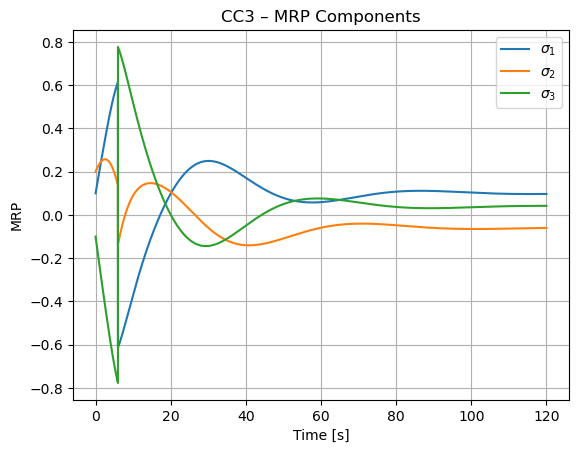

In [35]:
t = cc3_sim_results['t']
x = cc3_sim_results['x']
u = cc3_sim_results['u']

sigma = x[:, 0:3]
omega = x[:, 3:6]
omega_deg = np.rad2deg(omega)

plt.figure()
plt.plot(t, sigma[:, 0], label=r'$\sigma_1$')
plt.plot(t, sigma[:, 1], label=r'$\sigma_2$')
plt.plot(t, sigma[:, 2], label=r'$\sigma_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("CC3 – MRP Components")
plt.legend()
plt.show()

In [36]:
cc3_sim_results["sigma_BR"][-1]

array([ 0.09708434, -0.05996293,  0.04214907])

## 3.9.7 - CC4

In [37]:
def cc4_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    CC4 nonlinear attitude tracking controller with integral action.

    Control law:
        u_B = -K*sigma_BR - P*omega_BR_B
              + I*(omega_dot_RN_B - omega_BN_B x omega_RN_B)
              + omega_BN_B x (I*omega_BN_B)
              - (P*Ki)*z
              - modelL_B

    where
        z = K*eta + I*(omega_BR_B - omega_BR0_B)
        eta = integral_sigma_BR

    State
    -----
    state["sigma_BN"], state["omega_BN_B"]

    Reference
    ---------
    ref["sigma_RN"], ref["omega_RN_R"], ref["omega_dot_RN_R"]

    Context
    -------
    ctx["sc"]["I"]               : inertia matrix in B
    ctx["ctl"]["K"], ["P"], ["Ki"]
    ctx["ctl"]["integral_sigma_BR"]
    ctx["ctl"]["omega_BR0_B"]    optional
    ctx["ctl"]["modelL_B"]       optional disturbance model

    Returns
    -------
    u_B : control torque in body frame B
    """

    # --- unpack state ---
    sigma_BN = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega_BN_B = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)

    # --- unpack reference ---
    sigma_RN = np.asarray(ref.get("sigma_RN", np.zeros(3)), dtype=float).reshape(3,)
    omega_RN_R = np.asarray(ref.get("omega_RN_R", np.zeros(3)), dtype=float).reshape(3,)
    omega_dot_RN_R = np.asarray(ref.get("omega_dot_RN_R", np.zeros(3)), dtype=float).reshape(3,)

    # --- unpack context ---
    I = np.asarray(ctx["sc"]["I"], dtype=float).reshape(3, 3)
    K = float(ctx["ctl"]["K"])
    P = float(ctx["ctl"]["P"])
    Ki = np.asarray(ctx["ctl"].get("Ki", 0.0), dtype=float)
    eta = np.asarray(ctx["ctl"].get("integral_sigma_BR", np.zeros(3)), dtype=float).reshape(3,)
    omega_BR0_B = np.asarray(ctx["ctl"].get("omega_BR0_B", np.zeros(3)), dtype=float).reshape(3,)
    modelL_B = np.asarray(ctx["ctl"].get("modelL_B", np.zeros(3)), dtype=float).reshape(3,)

    # 1) attitude and rate error
    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    omega_RN_B = C_BR @ omega_RN_R
    omega_BR_B = omega_BN_B - omega_RN_B

    # 2) feedforward term
    omega_dot_RN_B = C_BR @ omega_dot_RN_R
    transport = np.cross(omega_BN_B, omega_RN_B)
    ff = I @ (omega_dot_RN_B - transport)

    # 3) integral structure
    dw = omega_BR_B - omega_BR0_B
    z = (K * eta) + (I @ dw)

    # 4) final control law
    u_B = (
        -K * sigma_BR
        -P * omega_BR_B
        + ff
        + np.cross(omega_BN_B, I @ omega_BN_B)
        - (P * Ki) * z
        - modelL_B
    )

    return u_B

In [38]:
# --- Parameters ---
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
Ki_q2 = 0.005  # (use this for the CC4 run if that's what your controller expects)
Ki_q4 = 0.0    # unused here unless you explicitly switch gains

deltaL_B = np.array([0.5, -0.3, 0.2], dtype=float)

sigma0 = np.array([0.1, 0.2, -0.1], dtype=float)
omega0_deg = np.array([3.0, 1.0, -2.0], dtype=float)

eta0 = np.zeros(3)


spacecraft_params = {
    "I": I,
    "L_B": deltaL_B,   # actual plant disturbance
}

controller_params = {
    "K": K,
    "P": P,
    "Ki": Ki_q4,
    "eta0": eta0,   # initialize integral state
    "modelL_B": np.zeros(3),     # controller disturbance model
}

simulation_config = {
    "t0": 0.0,
    "tf": 240.0,
    "dt": 0.01,
    "sigma0": sigma0,
    "omega0_deg": omega0_deg,
}

reference_config = {
    "mode": "tracking",
    "f": 0.05,
}

grading_config = {
    "time_s": 35.0,
    "quantity": "sigma_BR",
}

# --- Run ---
cc4_sim_results = simulate_CC(
    controller=cc4_controller_u,
    plant=cc_xdot_mrp,
    spacecraft_params=spacecraft_params,
    controller_params=controller_params,
    simulation_config=simulation_config,
    reference_config=reference_config,
    grading_config=grading_config,
)

cc4_sim_results


simulate_CC:   0%|          | 0.00/240.00 sim_s [00:00<?, ?sim_s/s]

simulate_CC completed in 8.269s (29.02× real-time, 29.02 sim_s/s)
CC: norm(sigma_BR) at t=35.000 s = 0.120285269666710


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 2.3998e+02, 2.3999e+02,
        2.4000e+02]),
 'x': array([[ 0.1       ,  0.2       , -0.1       ,  0.05235988,  0.01745329,
         -0.03490659],
        [ 0.10010299,  0.20004443, -0.10013171,  0.05235544,  0.01740952,
         -0.03484858],
        [ 0.100206  ,  0.20008871, -0.10026331,  0.052351  ,  0.01736571,
         -0.03479063],
        ...,
        [ 0.02265952,  0.22690136,  0.15088721,  0.05057786,  0.00254138,
         -0.03660782],
        [ 0.02273264,  0.2269452 ,  0.15074255,  0.05058197,  0.00251935,
         -0.03661358],
        [ 0.02280577,  0.22698897,  0.15059788,  0.05058607,  0.00249732,
         -0.03661934]]),
 'sigma_BN': array([[ 0.1       ,  0.2       , -0.1       ],
        [ 0.10010299,  0.20004443, -0.10013171],
        [ 0.100206  ,  0.20008871, -0.10026331],
        ...,
        [ 0.02265952,  0.22690136,  0.15088721],
        [ 0.02273264,  0.2269452 ,  0.15074255],
        [ 0.02280577,  0.226

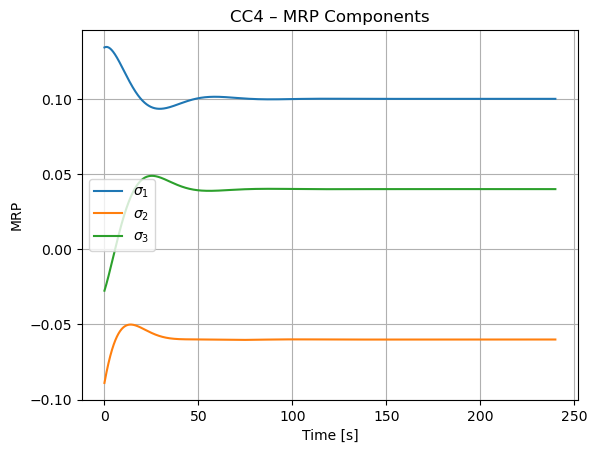

In [39]:
t = cc4_sim_results['t']
x = cc4_sim_results['x']
u = cc4_sim_results['u']

sigma_BR = cc4_sim_results['sigma_BR']

sigma = x[:, 0:3]
omega = x[:, 3:6]
omega_deg = np.rad2deg(omega)

plt.figure()
plt.plot(t, sigma_BR[:, 0], label=r'$\sigma_1$')
plt.plot(t, sigma_BR[:, 1], label=r'$\sigma_2$')
plt.plot(t, sigma_BR[:, 2], label=r'$\sigma_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("CC4 – MRP Components")
plt.legend()
plt.show()

In [40]:
cc4_sim_results['z'][-1]

array([121.10597164, -73.81677785,  45.63126376])

## 3.9.8 - CC5

In [41]:
def cc5_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    CC5 nonlinear attitude regulator with diagonal rate gains.

    Control law:
        u_B = -K*sigma_BN - P*omega_BN_B
              + omega_BN_B x (I*omega_BN_B)

    This is a pure regulation controller. The reference is assumed
    to be zero attitude and zero rate.

    Context
    -------
    ctx["sc"]["I"]  : inertia matrix in body frame B
    ctx["ctl"]["K"] : attitude gain
    ctx["ctl"]["P"] : rate gain
                      may be scalar, length 3 vector, or 3x3 diagonal matrix

    Returns
    -------
    u_B : control torque in body frame B
    """

    # --- unpack state ---
    sigma_BN = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega_BN_B = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)

    # --- unpack context ---
    I = np.asarray(ctx["sc"]["I"], dtype=float).reshape(3, 3)
    K = float(ctx["ctl"]["K"])
    P = np.asarray(ctx["ctl"]["P"], dtype=float)

    # 1) make P act as diagonal gain
    if P.ndim == 0:
        P_mat = np.diag(np.full(3, float(P)))
    elif P.shape == (3,):
        P_mat = np.diag(P)
    elif P.shape == (3, 3):
        P_mat = P
    else:
        raise ValueError("ctx['ctl']['P'] must be scalar, (3,), or (3,3)")

    # 2) control law
    u_B = (
        -K * sigma_BN
        -P_mat @ omega_BN_B
        + np.cross(omega_BN_B, I @ omega_BN_B)
    )

    return u_B

In [42]:
# CC5, Q1
# Given
I = np.diag([100.0, 75.0, 80.0])
K = 5.0


# For MRPs near zero: sigma_dot = 0.25 * omega
# Linearized closed-loop per axis: sigma_ddot + (P_i/I_i)*sigma_dot + (K/(4 I_i))*sigma = 0
# Match to: x_ddot + 2*zeta*wn*x_dot + wn^2*x = 0
# => wn^2 = K/(4 I_i), and 2*zeta*wn = P_i/I_i
# For critical damping (zeta=1): P_i = 2 I_i wn = sqrt(I_i*K)
P = np.sqrt(I * K)

P_diag = np.diag(P)

print(f"GainList, P = {P_diag}")

spacecraft_params = {
    "I": I,
    "L_B": np.zeros(3),   # unperturbed plant
}

controller_params = {
    "K": K,
    "P": P,           
    "modelL_B": np.zeros(3),
}

simulation_config = {
    "t0": 0.0,
    "tf": 120.0,
    "dt": 0.01,
    "sigma0": np.array([0.1, 0.2, -0.1]),
    "omega0_deg": np.array([30.0, 10.0, -20.0]),
}

reference_config = {
    "mode": "regulator",
    "f": 0.0,
}

grading_config = {
    "time_s": 30.0,
    "quantity": "sigma_BN",
}

cc5_sim_results = simulate_CC(
    controller=cc5_controller_u,
    plant=cc_xdot_mrp,
    spacecraft_params=spacecraft_params,
    controller_params=controller_params,
    simulation_config=simulation_config,
    reference_config=reference_config,
    grading_config=grading_config,
)
cc5_sim_results


GainList, P = [22.36067977 19.36491673 20.        ]


simulate_CC:   0%|          | 0.00/120.00 sim_s [00:00<?, ?sim_s/s]

simulate_CC completed in 3.613s (33.22× real-time, 33.22 sim_s/s)
CC: norm(sigma_BN) at t=30.000 s = 0.132721515753525


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 1.00000000e-01,  2.00000000e-01, -1.00000000e-01,
          5.23598776e-01,  1.74532925e-01, -3.49065850e-01],
        [ 1.01028894e-01,  2.00443985e-01, -1.01316601e-01,
          5.22377881e-01,  1.73947730e-01, -3.48131496e-01],
        [ 1.02056089e-01,  2.00885824e-01, -1.02630959e-01,
          5.21159203e-01,  1.73363755e-01, -3.47198652e-01],
        ...,
        [ 1.21536223e-05, -6.85712119e-07, -4.62113963e-06,
         -5.05348191e-06,  3.22275164e-07,  2.15792439e-06],
        [ 1.21409952e-05, -6.84906914e-07, -4.61574795e-06,
         -5.04825879e-06,  3.21900194e-07,  2.15541779e-06],
        [ 1.21283810e-05, -6.84102646e-07, -4.61036253e-06,
         -5.04304104e-06,  3.21525656e-07,  2.15291409e-06]]),
 'sigma_BN': array([[ 1.00000000e-01,  2.00000000e-01, -1.00000000e-01],
        [ 1.01028894e-01,  2.00443985e-01, -1.01316601e-01],
        [ 1.02056089

In [43]:
wn = np.sqrt(K / (4.0 * np.diag(I)))   # rad/s
T = 1.0 / wn                       # seconds

T.tolist()  # [T1, T2, T3]


[8.94427190999916, 7.745966692414835, 8.0]

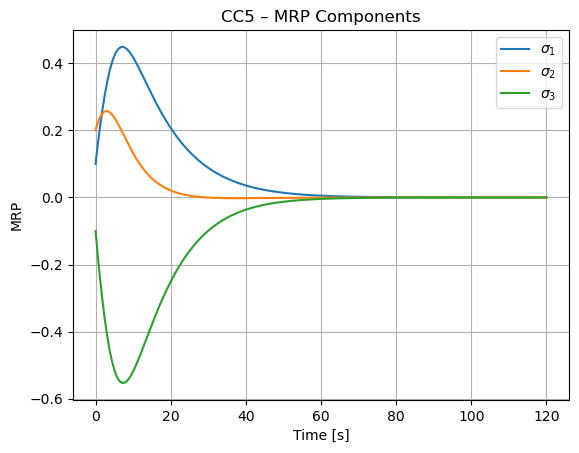

In [44]:
t = cc5_sim_results['t']
x = cc5_sim_results['x']
u = cc5_sim_results['u']

sigma_BN = cc5_sim_results['sigma_BN']

sigma = x[:, 0:3]
omega = x[:, 3:6]
omega_deg = np.rad2deg(omega)

plt.figure()
plt.plot(t, sigma_BN[:, 0], label=r'$\sigma_1$')
plt.plot(t, sigma_BN[:, 1], label=r'$\sigma_2$')
plt.plot(t, sigma_BN[:, 2], label=r'$\sigma_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("CC5 – MRP Components")
plt.legend()
plt.show()

---

Notes compiled and structured by John Gracious